In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
import numba   
import pickle
from pcygni_5 import PcygniCalculator as PcygniCalculator_old
from pcygni_5_Spec_Rel import PcygniCalculator

import astropy.units as units
import astropy.constants as csts
from scipy.interpolate import interp1d
import lmfit
import time

#My plot style to standardize my plot esthetics
def reset_plt(ticksize,fontsize):
    plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['axes.formatter.limits'] = (-1,3)
    plt.rcParams['axes.linewidth'] = 2.25
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.6
    #plt.rcParams['pcolor.shading'] = 'nearest'
    
def put_ticks(this_fig,this_ax):
    this_ax.xaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, right = True)
    this_ax.xaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, right = True)
    dx = -3/72
    dy = -3/72
    y_offset = matplotlib.transforms.ScaledTranslation(0, dy, this_fig.dpi_scale_trans)
    x_offset = matplotlib.transforms.ScaledTranslation(dx, 0, this_fig.dpi_scale_trans)

    for label in this_ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + y_offset)

    for label in this_ax.yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + x_offset)
        
import math
pi = np.pi; h = 6.626e-34; c = 3.0e+8; k = 1.38e-23

In [2]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)
    warnings.warn("IntegrationWarning", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    
import warnings
warnings.filterwarnings("ignore")

In [3]:
OB = 'OB1'

In [4]:
path = './spectra_filtered' #\AT2017gfo\AT2017gfo\dereddened+deredshifted_spectra' 
files = os.listdir(path)

x = np.loadtxt(path+'/'+files[0]).T
#x= np.array([wl, flux, error,error]).T
exc_reg_2 = (~((x[:,0] > 13100) & (x[:,0] < 14400))) & \
            (~((x[:,0] > 17550) & (x[:,0] < 19200))) & \
            (~((x[:,0] > 5330) & (x[:,0] < 5740))) & \
            (~((x[:,0] > 9840) & (x[:,0] < 10300))) & \
            (x[:,0] > 3300) & (x[:,0] < 22500) #22500

wl, flux, error = x[:,0][exc_reg_2], x[:,1][exc_reg_2], x[:,2][exc_reg_2]

error = error * 2.26

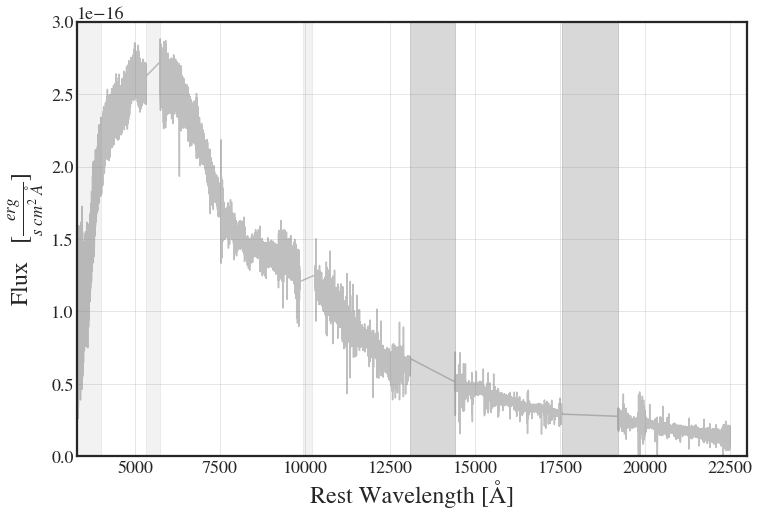

In [5]:
reset_plt(18,24)
fig,ax = plt.subplots(figsize=(12,8))
plt.plot(wl, flux, label='X-shooter spectra', color='grey', alpha=0.5)

#plt.plot(wl,flux_fit, ls='--', color='k', label='Blackbody-fit')
#plt.fill_between(x[:,0], x[:,1]-x[:,2], x[:,1]+x[:,2],color='grey', alpha=0.9)
plt.ylim(0, 3e-16), plt.xlim(3300, 23000)

#define telluric region
ax.fill_between([13100, 14400], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )
ax.fill_between([17550, 19200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )

#poorly constrained regions
ax.fill_between([5330, 5740], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1   )
ax.fill_between([9940, 10200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

#define absorbtion feature
#ax.fill_between([7000, 9000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )
ax.fill_between([3000, 4000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

plt.xlabel('Rest Wavelength [Å]'), plt.ylabel(r'Flux   $ [ \frac{erg}{s \ cm^2 \ Å} ] $'), 
ax.ticklabel_format(axis='x', style='plain')
#plt.xlim(9000,12000)
#plt.xscale('log') 
#plt.savefig('Pictures/Second_epoch_OB1_emcee_no_gaussian.png', dpi=300)

In [6]:
from astropy.modeling import models

def p_cygni_line_corr(wl, v_out, v_phot, tau, lam, vref=0.2, ve=0.2, t0 = 120960): 
    prof_calc = PcygniCalculator(t=t0 * units.s, vmax=v_out * csts.c,
                                 vphot=v_phot * csts.c, tauref=tau, vref=vref *
                                 csts.c, ve=ve * csts.c,
                                 lam0=lam * units.AA)#, _lam_min=7000, _lam_max=13000)
    
    cyg = prof_calc.calc_profile_Flam( npoints=25 )  
    
    inter = interp1d(cyg[0].value*1e-10, cyg[1], bounds_error=False, fill_value=1)    
    return inter(wl)

@numba.njit(fastmath=True)
def temp(wav,T):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    return a/ ( (wav**5)*(np.exp(b) - 1.0) )
    
@numba.njit(fastmath=True)
def gaussian(wav, amp, mu, sigma): 
    return amp*np.exp(-(wav-mu)**2/(2*sigma**2))
    
def planck_with_mod(wav, T, N, v_out, v_phot, tau=0.55, occul = 1, ve=0.32,
                    amp1 = 2, cen1=15500, sig1=250,amp2 = 2, cen2=15500, sig2=250, 
                    vref=0., t0=120960, lam=10506.3653, tau2 = 0.0, lam2=7000, tau3=0.0, lam3 = 10000): #blackbody

    intensity = temp(wav, T)
    
    pcyg_prof3 = p_cygni_line_corr(wav, v_out, v_phot, 1/13.8*tau   , 10036.65, vref=vref, ve=ve , t0=t0)
    pcyg_prof4 = p_cygni_line_corr(wav, v_out, v_phot, 8.1/13.8*tau , 10327.311,vref=vref, ve=ve , t0=t0)
    pcyg_prof5 = p_cygni_line_corr(wav, v_out, v_phot, 4.7/13.8*tau , 10914.887,vref=vref, ve=ve , t0=t0)

    #pcyg_prof_novel = p_cygni_line_corr(wav, v_out, v_phot, tau2 , lam2, vref=vref, ve=ve , t0=t0)
    #pcyg_prof_novel2 = p_cygni_line_corr(wav, v_out, v_phot, tau2 , lam2, vref=vref, ve=ve , t0=t0)
    
    correction = pcyg_prof3*pcyg_prof4*pcyg_prof5#*pcyg_prof_novel*pcyg_prof_novel2
    correction[correction>1] = (correction[correction>1]-1)*occul + 1
    

    # Gaussians
    gau1 = gaussian(wav, 1e-17*amp1, cen1, sig1)
    gau2 = gaussian(wav, 1e-17*amp2, cen2, sig2)
    
    intensity = intensity*correction
    return N*intensity+gau1+gau2


def residual(pars, wav, data=None, error=None): 
    v = pars.valuesdict()
    T, N, vphot = v["T"], v["N"], v["vphot"]
    t0, vmax, tau, vref, ve, occult2 = v["t0"], v["vmax"], v["tau"], v["vref"], v["ve"], v["occult"]
    amp1, amp2, cen1, cen2, sig1, sig2= v["amp1"], v["amp2"], v["cen1"], v["cen2"], v["sig1"], v["sig2"]
    
    #tau2, lam2 = v["tau2"], v["lam2"]
    #tau3, lam3 = v["tau3"], v["lam3"]

    model = planck_with_mod(wav, T, N, vmax, vphot, tau=tau, occul=occult2, ve = ve, vref = vref, 
                           amp1 = amp1, cen1=cen1, sig1=sig1, amp2 = amp2, cen2=cen2, sig2=sig2) #, 
                           #tau2=tau2, lam2=lam2, tau3=tau3, lam3=lam3)
    
    if data is None:
        return model
    return (model - data)/error

import lmfit

beta, doppler = np.loadtxt('doppler_wo_prolate_inv.txt')
inter = interp1d(beta, doppler)

def lum_dist_arr(N, vphot, n_days=1.43, dt=0.): #propagate bb to luminosity distance 

    delta = inter(vphot) #1-2/3*11/10*vphot
    corr = delta**4
        
    #theta = 2*np.sqrt( N*10**(7) /(1-vphot)*corr )#**5)/np.pi ) #regular
    theta = 2*np.sqrt( N*10**(7) / corr )#**5)/np.pi ) #inverse

    v = vphot*c 
    t = (n_days-dt) * (3600*24)
    r = v*t
    
    D = r/theta*2# factor of 2 
    D_mpc = D*(3.2408e-23) 
    return D_mpc

n_days = [1.427, 2.417, 3.413, 4.403]

In [7]:
@numba.njit(fastmath=True)
def lnprob_inner(model, flux, error):
    return -0.5 * np.sum(((model - flux) / error)**2 + np.log(2 * np.pi * error**2))

def lnprob(pars):
    """This is the log-likelihood probability for the sampling."""    
    model = residual(pars, wl*1e-10)
    return lnprob_inner(model, flux, error)

In [ ]:
lum_dist_arr(p['N'], p['vphot'])

Parameters([('T', <Parameter 'T', value=5406.278581254397 +/- 4.93, bounds=[2500:7500]>), ('N', <Parameter 'N', value=1.3735724567603175e-29 +/- 6.44e-32, bounds=[-inf:inf]>), ('vphot', <Parameter 'vphot', value=0.2900099381071706 +/- 0.00262, bounds=[0:1]>), ('vmax', <Parameter 'vmax', value=0.427968002709116 +/- 0.00422, bounds=[0:1]>), ('t0', <Parameter 't0', value=123552.0 (fixed), bounds=[-inf:inf]>), ('tau', <Parameter 'tau', value=24.07405065325984 +/- 0.934, bounds=[0:100]>), ('vref', <Parameter 'vref', value=0.0 (fixed), bounds=[0:1]>), ('ve', <Parameter 've', value=0.0894477531248336 +/- 0.00134, bounds=[0:1]>), ('occult', <Parameter 'occult', value=0.0021492272761205887 +/- 7.91e-05, bounds=[0:2]>), ('amp1', <Parameter 'amp1', value=0.23471261247070246 +/- 0.00532, bounds=[0:5]>), ('amp2', <Parameter 'amp2', value=0.43494819904501 +/- 0.00762, bounds=[0:5]>), ('cen1', <Parameter 'cen1', value=1.5172946306510827e-06 +/- 8.18e-09, bounds=[1.4e-06:1.7e-06]>), ('cen2', <Parameter 'cen2', value=1.932426551417865e-06 +/- 8.72e-09, bounds=[1.9e-06:2.2e-06]>), ('sig1', <Parameter 'sig1', value=4.630483150059241e-08 +/- 5.52e-10, bounds=[1e-08:3e-07]>), ('sig2', <Parameter 'sig2', value=1.6924226450702125e-07 +/- 2.38e-09, bounds=[1e-08:3e-07]>)])

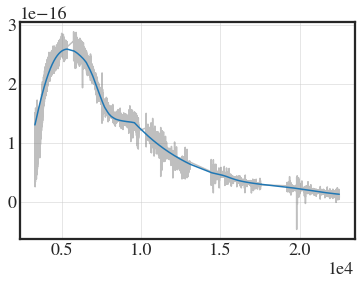

In [14]:
pickle_in = open("./data/OB1/Rel/Rel_3_including_delta_source.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
#p['occult'].value = 1
#p['ve'].value = 1
#p['tau'].value = 10
p['t0'].value = 3600*24*1.43
plt.plot(wl, flux, label='X-shooter spectra', color='grey', alpha=0.5)

plt.plot(wl, residual(p, wl*1e-10))
p

In [9]:
p

Parameters([('T', <Parameter 'T', value=5406.278581254397 +/- 4.93, bounds=[2500:7500]>), ('N', <Parameter 'N', value=1.3735724567603175e-29 +/- 6.44e-32, bounds=[-inf:inf]>), ('vphot', <Parameter 'vphot', value=0.2900099381071706 +/- 0.00262, bounds=[0:1]>), ('vmax', <Parameter 'vmax', value=0.427968002709116 +/- 0.00422, bounds=[0:1]>), ('t0', <Parameter 't0', value=123552.0 (fixed), bounds=[-inf:inf]>), ('tau', <Parameter 'tau', value=24.07405065325984 +/- 0.934, bounds=[0:100]>), ('vref', <Parameter 'vref', value=0.0 (fixed), bounds=[0:1]>), ('ve', <Parameter 've', value=0.0894477531248336 +/- 0.00134, bounds=[0:1]>), ('occult', <Parameter 'occult', value=0.0021492272761205887 +/- 7.91e-05, bounds=[0:2]>), ('amp1', <Parameter 'amp1', value=0.23471261247070246 +/- 0.00532, bounds=[0:5]>), ('amp2', <Parameter 'amp2', value=0.43494819904501 +/- 0.00762, bounds=[0:5]>), ('cen1', <Parameter 'cen1', value=1.5172946306510827e-06 +/- 8.18e-09, bounds=[1.4e-06:1.7e-06]>), ('cen2', <Parameter 'cen2', value=1.932426551417865e-06 +/- 8.72e-09, bounds=[1.9e-06:2.2e-06]>), ('sig1', <Parameter 'sig1', value=4.630483150059241e-08 +/- 5.52e-10, bounds=[1e-08:3e-07]>), ('sig2', <Parameter 'sig2', value=1.6924226450702125e-07 +/- 2.38e-09, bounds=[1e-08:3e-07]>)])

[-1.00499975e-02 -1.00312549e-02 -9.97502315e-03 -9.88128958e-03
 -9.75003334e-03 -9.58122515e-03 -9.37482729e-03 -9.13079360e-03
 -8.84906939e-03 -8.52959139e-03 -8.17228769e-03 -7.77707763e-03
 -7.34387175e-03 -6.87257166e-03 -6.36306991e-03 -5.81524990e-03
 -5.22898575e-03 -4.60414210e-03 -3.94057400e-03 -3.23812673e-03
 -2.49663558e-03 -1.71592569e-03 -8.95811836e-04 -3.60981544e-05
  8.63422053e-04  1.80296660e-03  2.78276470e-03  3.80305723e-03
  4.86409711e-03  5.96614957e-03  7.10949254e-03  8.29441703e-03
  9.52122753e-03  1.07902424e-02  1.21017944e-02  1.34562312e-02
  1.48539156e-02  1.62952265e-02  1.77805592e-02  1.93103261e-02
  2.08849573e-02  2.25049014e-02  2.41706261e-02  2.58826192e-02
  2.76413891e-02  2.94474659e-02  3.13014026e-02  3.32037754e-02
  3.51551857e-02  3.71562604e-02]


(-0.1, 0.1)

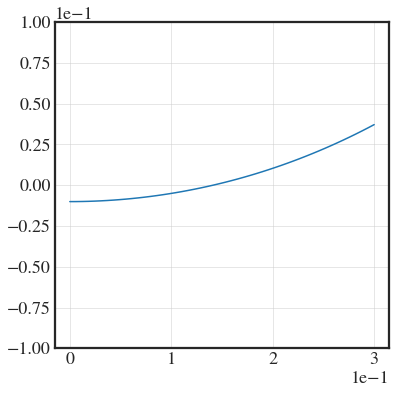

In [10]:
plt.figure(figsize=(6,6))
c = 29979245800
t = 120960
delta = 0.99
p = np.linspace(0, 0.3*c*t)
#corr = 
z = c*t*( delta**2/(1+delta**2) - delta**2/(1+delta**2) * (1-(1+delta**2)/delta**4*( (p/c/t)**2-(1-delta**2)))**(1/2) )

print(z/c/t)
#(c*t*delta**2/(1+delta**2) * (1 + ( 1 + (1+delta**2)/delta**2 *((1-delta**2)-(p/c/t)**2))**(1/2) ))/(c*t)
plt.plot(p/c/t, z/c/t)

#c = 29979245800
#t = 120960
#delta = 1.1
#p = np.linspace(0, 0.3*c*t)
#z = c*t/(1+delta**2) * ( delta**2 + (delta**2-(1-delta**2)*( (p/c/t)**2-(1-delta**2)))**1/2 ) 
#plt.plot(p/c/t, z/c/t, ls='--')
#z = (c*t*delta**2/(1+delta**2) * (1 - ( 1 + (1+delta**2)/delta**2 *((1-delta**2)-(p/c/t)**2))**(1/2) ))/(c*t)
#plt.plot(p/c/t, z, ls='dotted', color='C1')

#plt.axhline(1)

plt.ylim(-0.1, 0.1)

0.18032786885245894
0.09502262443438925
0.0
-0.10497237569060774
-0.21951219512195114


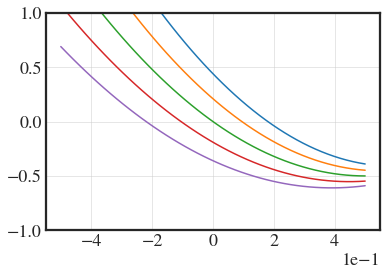

In [11]:
z = np.linspace(-0.5, 0.5)

for delta in [1.2, 1.1, 1, 0.9, 0.8]:
    p = 0.0
    y = (1+delta**2) * z**2 - (2*delta**2)*z - (1-delta**2) + p**2

    plt.plot(z, y)
    plt.ylim(-1, 1)
    
    print( delta**2/(1+delta**2) - delta**2/(1+delta**2)*(1-(1+delta**2)/delta**4*(p**2-(1-delta**2)))**(1/2) )

-0.21951219512195114
-0.2144915252788993
-0.1991729743216864
-0.17271653110164825


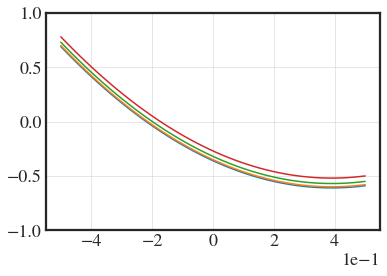

In [12]:
z = np.linspace(-0.5, 0.5)

for p in [0, 0.1, 0.2, 0.3]:
    delta = 0.80
    y = (1+delta**2) * z**2 - (2*delta**2)*z - (1-delta**2) + p**2

    plt.plot(z, y)
    plt.ylim(-1, 1)
    
    print( delta**2/(1+delta**2) - delta**2/(1+delta**2)*(1-(1+delta**2)/delta**4*(p**2-(1-delta**2)))**(1/2) )

In [15]:
start = time.time()
mi2 = lmfit.minimize(residual, p, method='Nelder', args=(wl*1e-10, flux, error))
end = time.time()
print('Time elapsed:',(end-start)/60) 

p = mi2.params

Time elapsed: 0.9964216907819112


In [24]:
p = mi2.params
p

Parameters([('T', <Parameter 'T', value=5415.625502400263, bounds=[2500:7500]>), ('N', <Parameter 'N', value=1.3648760389061216e-29, bounds=[-inf:inf]>), ('vphot', <Parameter 'vphot', value=0.289298308877754, bounds=[0:1]>), ('vmax', <Parameter 'vmax', value=0.43413979588855006, bounds=[0:1]>), ('t0', <Parameter 't0', value=123552.0 (fixed), bounds=[-inf:inf]>), ('tau', <Parameter 'tau', value=22.32088754301831, bounds=[0:100]>), ('vref', <Parameter 'vref', value=0.0 (fixed), bounds=[0:1]>), ('ve', <Parameter 've', value=0.08708115950896012, bounds=[0:1]>), ('occult', <Parameter 'occult', value=0.002134714485786171, bounds=[0:2]>), ('amp1', <Parameter 'amp1', value=0.2486606728225793, bounds=[0:5]>), ('amp2', <Parameter 'amp2', value=0.4887293066843859, bounds=[0:5]>), ('cen1', <Parameter 'cen1', value=1.517493815020354e-06, bounds=[1.4e-06:1.7e-06]>), ('cen2', <Parameter 'cen2', value=1.9303577458647437e-06, bounds=[1.9e-06:2.2e-06]>), ('sig1', <Parameter 'sig1', value=4.6608553672740126e-08, bounds=[1e-08:3e-07]>), ('sig2', <Parameter 'sig2', value=1.696134777275799e-07, bounds=[1e-08:3e-07]>)])

In [31]:
beta, doppler = np.loadtxt('./codes - Diluted BB/Derivation_conv_Sadun.txt')
inter = interp1d(beta, doppler)
c = 3.0e+8
    
def lum_dist_arr(N, vphot, n_days=1.43, dt=0.): #propagate bb to luminosity distance 
    delta = inter(vphot) #v_perp, 1-2/3*11/10*vphot
    corr = delta#/inter2(vphot)**2#**4
        
    theta = 2*np.sqrt( N*10**(7) / corr ) #inverse
    v = vphot*c 
    t = (n_days-dt) * (3600*24)
    r = v*t
    
    D = r/theta*2# factor of 2 
    D_mpc = D*(3.2408e-23) 
    return D_mpc

lum_dist_arr(mi2.params['N'], mi2.params['vphot'])

41.741931224275405

In [36]:
41.741931224275405/41.00459507818315

1.0179817931304134

In [33]:
mi2.params['vphot']/p['vphot']

1.040881375255299

In [35]:
mi2.params['N']/p['N']

1.0232873093202273

In [34]:
pickle_in = open("./data/OB1/OB1_3_peaks_with_gaussian_3.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params

print(lum_dist_arr(p['N'], p['vphot']))
p

41.00459507818315


Parameters([('T', <Parameter 'T', value=5440.8967947121055 +/- 2.46, bounds=[2500:7500]>), ('N', <Parameter 'N', value=1.3338150746859284e-29 +/- 3.14e-32, bounds=[-inf:inf]>), ('vphot', <Parameter 'vphot', value=0.27793590677592556 +/- 0.000611, bounds=[0:1]>), ('vmax', <Parameter 'vmax', value=0.3435875538574039 +/- 0.000707, bounds=[0:1]>), ('t0', <Parameter 't0', value=126000 (fixed), bounds=[-inf:inf]>), ('tau', <Parameter 'tau', value=19.888946177308384 +/- 4.76, bounds=[0:100]>), ('vref', <Parameter 'vref', value=0.0 (fixed), bounds=[0:1]>), ('ve', <Parameter 've', value=0.08640330243076558 +/- 0.00664, bounds=[0:1]>), ('occult', <Parameter 'occult', value=0.011108657158602665 +/- 0.039, bounds=[0:2]>), ('amp1', <Parameter 'amp1', value=0.29438175177851106 +/- 0.00725, bounds=[0:5]>), ('amp2', <Parameter 'amp2', value=0.478174226138591 +/- 0.00505, bounds=[0:5]>), ('cen1', <Parameter 'cen1', value=1.5201852353110815e-06 +/- 1.56e-09, bounds=[1.4e-06:1.7e-06]>), ('cen2', <Parameter 'cen2', value=1.9228052277798637e-06 +/- 1.37e-09, bounds=[1.9e-06:2.2e-06]>), ('sig1', <Parameter 'sig1', value=5.596019384649572e-08 +/- 2.16e-09, bounds=[1e-08:3e-07]>), ('sig2', <Parameter 'sig2', value=1.757049301539864e-07 +/- 4e-09, bounds=[1e-08:3e-07]>)])

#### Fit structure

In [14]:
pickle_in = open("./data/OB1/Rel/Rel_long_Occult_Free.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
#p['occult'].value = 1
#p['occult'].vary = False
p['t0'].value = 3600*24*1.43


mini = lmfit.Minimizer(lnprob, p) 

start = time.time()
nwalkers = 30 #v = p.valuesdict()
res5 = mini.emcee(nwalkers=nwalkers, burn=0, steps=500, thin=1, params=p, seed=1, workers = 4)
end = time.time()

print('Time elapsed [hours]:',(end-start)/60/60 ) 

100%|██████████| 500/500 [18:31<00:00,  2.22s/it]


The chain is shorter than 50 times the integrated autocorrelation time for 13 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10;
tau: [43.57114726 42.93962381 52.21290962 39.34760305 52.93423658 47.70196707
 49.26528545 52.09079161 40.2682536  41.10953666 36.76719756 48.8834536
 41.21354481]
Time elapsed [hours]: 0.3096446232663261


0.28702189072562534 0.002610553227734786


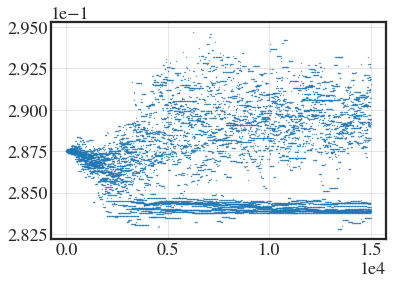

In [15]:
plt.scatter( np.arange(len(res5.flatchain['vphot'])), res5.flatchain['vphot'], s=0.1)
print(np.mean(res5.flatchain['vphot']), np.std(res5.flatchain['vphot'])  )

In [9]:
path = './spectra_filtered' #\AT2017gfo\AT2017gfo\dereddened+deredshifted_spectra' 
files = os.listdir(path)

x = np.loadtxt(path+'/'+files[0]).T

exc_reg_2 = (~((x[:,0] > 13100) & (x[:,0] < 14400))) & (~((x[:,0] > 17550) & (x[:,0] < 19200))) & \
          (~((x[:,0] > 5330) & (x[:,0] < 5740))) & (~((x[:,0] > 9840) & (x[:,0] < 10300))) & \
          (~((x[:,0] > 10000) & (x[:,0] < 11500))) & \
          (x[:,0] > 3300) & (x[:,0] < 22500)

wl, flux, error = x[:,0][exc_reg_2], x[:,1][exc_reg_2], x[:,2][exc_reg_2]

mini = lmfit.Minimizer(lnprob, p) 

start = time.time()
nwalkers = 100 #v = p.valuesdict()
res6 = mini.emcee(nwalkers=nwalkers, burn=0, steps=2000, thin=1, params=p, seed=1, workers = 4)
end = time.time()

print('Time elapsed [hours]:',(end-start)/60/60 ) 

100%|██████████| 2000/2000 [1:15:32<00:00,  2.27s/it]


The chain is shorter than 50 times the integrated autocorrelation time for 13 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 40;
tau: [250.63534935 254.66911508 109.57232698 263.75972301 268.74128988
 269.38106273 209.74908465 229.0440387  232.70231473 147.96365498
 189.8960485  180.3882997  187.96708532]
Time elapsed [hours]: 1.259904945426517


0.2874495430983085 0.0033487503207982766
0.2898365914938873 0.0017181703235432174


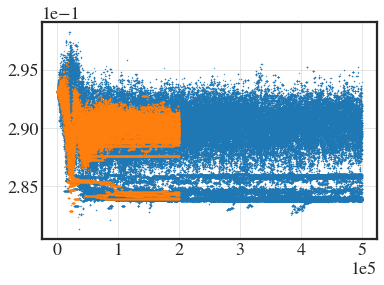

In [11]:
plt.scatter( np.arange(len(res5.flatchain['vphot'])), res5.flatchain['vphot'], s=0.1)
print(np.mean(res5.flatchain['vphot']), np.std(res5.flatchain['vphot'])  )

plt.scatter( np.arange(len(res6.flatchain['vphot'])), res6.flatchain['vphot'], s=0.1)
print(np.mean(res6.flatchain['vphot']), np.std(res6.flatchain['vphot'])  )
#p

In [33]:
plt.scatter( np.arange(len(res5.flatchain['vphot'])), res5.flatchain['occult'], s=0.1)


KeyError: 'occult'

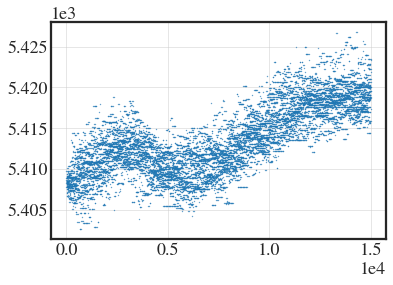

In [25]:
plt.scatter( np.arange(len(res5.flatchain['vphot'])), res5.flatchain['T'], s=0.1)


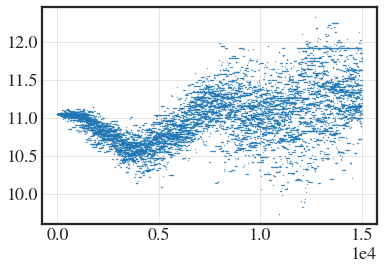

In [29]:
plt.scatter( np.arange(len(res5.flatchain['vphot'])), res5.flatchain['tau'], s=0.1)


In [ ]:
res

In [16]:
file = "./Data/OB1/Rel/Rel_7.pkl"
with open(file, 'wb') as outfile:
    pickle.dump(res5, outfile)

In [13]:
file = "./Data/OB1/Rel/Rel_long_Occult_Free_No_Emission.pkl"
with open(file, 'wb') as outfile:
    pickle.dump(res6, outfile)

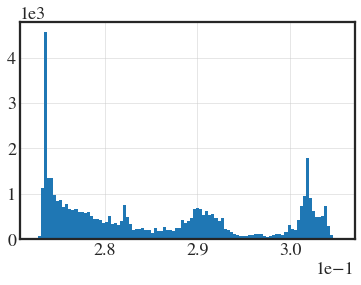

In [26]:
plt.hist(res5.flatchain['vphot'], bins=100); 

In [19]:
np.mean(res4.flatchain['vphot'])

0.29011418515063137

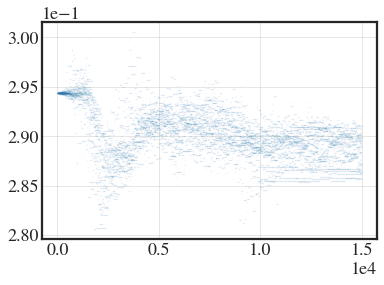

In [13]:
plt.scatter(np.arange(len(res4.flatchain['vphot'])), res4.flatchain['vphot'], s=0.1, alpha=0.1); 

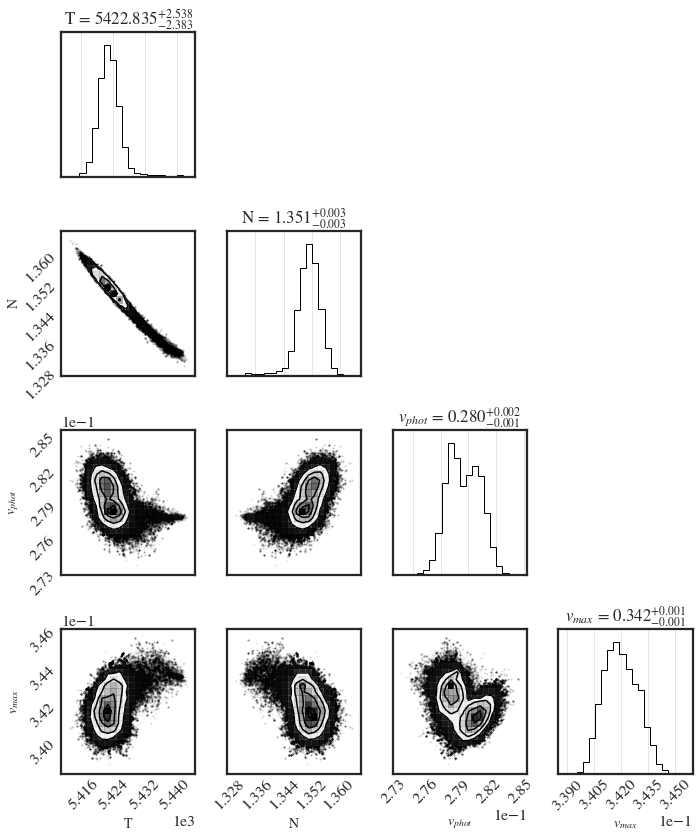

In [22]:
import corner 
flat = res4.flatchain 

n_box = 4
fig,ax = plt.subplots(figsize=(10,12),nrows=n_box,ncols=n_box)
#ax = ax.flatten()
reset_plt(16, 14)
corner.corner( np.array([flat['T'], flat['N']*1e29, flat['vphot'], flat['vmax']]).T, 
              labels=['T', 'N', r'$v_{phot}$', r'$v_{max}$'], 
              show_titles=True, fig=fig, title_fmt = '.3f'); 
plt.tight_layout() 

#plt.savefig('Pictures/OB1_covariance_inflated_unc.png', dpi=300)

In [57]:
#p = lmfit.Parameters()
#OB = 'OB1'
#with open("./data/%s_init.json"%OB, 'r') as infile:
#    p.load(infile)
pickle_in = open("./data/OB1/OB1_3_peaks_with_gaussian_3.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
print(lum_dist_arr(p['N'],p['vphot'],n_days=1.43), p['ve'], p['vphot'])

#p['occult'].vary=False; p['occult'].value=1
p.add('tau2', value=0.5, min=0, max=100)
p.add('lam2', value=9000, min=7000, max=12000)
p
p['amp1'].vary=False; p['amp2'].vary=False; 
p['sig1'].vary=False; p['sig2'].vary=False; 
p['cen1'].vary=False; p['cen2'].vary=False; 

start = time.time()
mi2 = lmfit.minimize(residual, p, method='Nelder', args=(wl*1e-10, flux, error))
end = time.time()
print('Time elapsed:',(end-start)/60) 

42.951127642884344 <Parameter 've', value=0.08640330243076558 +/- 0.00664, bounds=[0:1]> <Parameter 'vphot', value=0.27793590677592556 +/- 0.000611, bounds=[0:1]>
Time elapsed: 0.8123989939689636


In [58]:
lum_dist_arr(mi2.params['N'],mi2.params['vphot'],n_days=1.43), #p['ve'], p['vphot']


(42.17462803560535,)

In [59]:
mi2.params['vphot']

<Parameter 'vphot', value=0.27332726045385797, bounds=[0:1]>

In [60]:
mi2.params

Parameters([('T', <Parameter 'T', value=5452.986006549998, bounds=[2500:7500]>), ('N', <Parameter 'N', value=1.3210779064186115e-29, bounds=[-inf:inf]>), ('vphot', <Parameter 'vphot', value=0.27332726045385797, bounds=[0:1]>), ('vmax', <Parameter 'vmax', value=0.3408521930791605, bounds=[0:1]>), ('t0', <Parameter 't0', value=126000 (fixed), bounds=[-inf:inf]>), ('tau', <Parameter 'tau', value=19.608421230388238, bounds=[0:100]>), ('vref', <Parameter 'vref', value=0.0 (fixed), bounds=[0:1]>), ('ve', <Parameter 've', value=0.08442015138721148, bounds=[0:1]>), ('occult', <Parameter 'occult', value=0.015169646902505995, bounds=[0:2]>), ('amp1', <Parameter 'amp1', value=0.29438175177851106 (fixed), bounds=[0:5]>), ('amp2', <Parameter 'amp2', value=0.478174226138591 (fixed), bounds=[0:5]>), ('cen1', <Parameter 'cen1', value=1.5201852353110815e-06 (fixed), bounds=[1.4e-06:1.7e-06]>), ('cen2', <Parameter 'cen2', value=1.9228052277798637e-06 (fixed), bounds=[1.9e-06:2.2e-06]>), ('sig1', <Parameter 'sig1', value=5.596019384649572e-08 (fixed), bounds=[1e-08:3e-07]>), ('sig2', <Parameter 'sig2', value=1.757049301539864e-07 (fixed), bounds=[1e-08:3e-07]>), ('tau2', <Parameter 'tau2', value=0.5933402061364279, bounds=[0:100]>), ('lam2', <Parameter 'lam2', value=9018.723207864223, bounds=[7000:12000]>)])

In [42]:
#with open("./data/%s_3.json"%OB, 'w') as outfile:
#    mi2.params.dump(outfile)

In [12]:
#with open("./data/%s_3.json"%OB, 'w') as outfile:
#    mi2.params.dump(outfile)p = lmfit.Parameters()
with open("./Data/%s_3.json"%OB, 'r') as infile:
    p.load(infile)

#p
lum_dist_arr(p['N'],p['vphot'],n_days=1.45), p['ve'], p['vphot']

# OB1_1 : free ve
# OB1_2 : free ve
# OB1_3 : fixed ve [0,0.1]

(37.52973938225238,
 <Parameter 've', value=0.07748344394755043, bounds=[0:0.1]>,
 <Parameter 'vphot', value=0.25030193847114246, bounds=[0:1]>)

(2.0962143037034062, 2.0962143037034062)

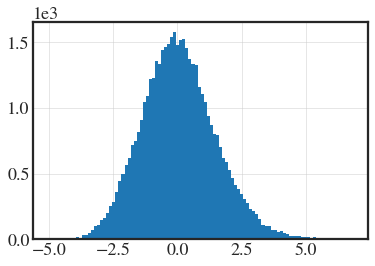

In [18]:
chi = (flux_theo-flux)/error
plt.hist(chi, bins=100); 
np.mean(chi**2), np.sum(chi**2)/len(chi)

In [62]:
pickle_in = open("./data/OB1/OB1_3_peaks_with_gaussian_2.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
#print(lum_dist_arr(p['N'],p['vphot'],n_days=1.43), p['ve'], p['vphot'])

#p['sig1'].value = 0.55e-7; p['sig2'].value = 1.10e-7; 
#p['sig1'].vary=False; p['sig2'].vary=False; 
#p['amp1'].min = 0; p['amp2'].min = 0; 
#p['amp1'].vary=False; p['amp2'].vary=False; 
#p['sig1'].vary=False; p['sig2'].vary=False; 
p['cen1'].vary=True; p['cen2'].vary=True; 
#p['amp1'].value = 0.001; p['amp2'].value = 0.001;
#p['cen2'].value=2.03e-6; p['sig2'].value=7.2e-8; 

p

Parameters([('T', <Parameter 'T', value=5435.716791746477 +/- 4.42, bounds=[2500:7500]>), ('N', <Parameter 'N', value=1.3404076532489784e-29 +/- 4.83e-32, bounds=[-inf:inf]>), ('vphot', <Parameter 'vphot', value=0.27768223610679355 +/- 0.00191, bounds=[0:1]>), ('vmax', <Parameter 'vmax', value=0.34633402047380324 +/- 0.00114, bounds=[0:1]>), ('t0', <Parameter 't0', value=126000 (fixed), bounds=[-inf:inf]>), ('tau', <Parameter 'tau', value=35.43711858345176 +/- 11.7, bounds=[0:100]>), ('vref', <Parameter 'vref', value=0.0 (fixed), bounds=[0:1]>), ('ve', <Parameter 've', value=0.07449505547902187 +/- 0.00639, bounds=[0:1]>), ('occult', <Parameter 'occult', value=0.0005456328535526188 +/- 2.25e-05, bounds=[0:2]>), ('amp1', <Parameter 'amp1', value=0.26169986240919846 +/- 0.0123, bounds=[0:5]>), ('amp2', <Parameter 'amp2', value=0.43011965591121504 +/- 0.0365, bounds=[0:5]>), ('cen1', <Parameter 'cen1', value=1.55e-06, bounds=[1.4e-06:1.7e-06]>), ('cen2', <Parameter 'cen2', value=2.03e-06, bounds=[1.9e-06:2.2e-06]>), ('sig1', <Parameter 'sig1', value=1.234466933355993e-07 +/- 8.44e-09, bounds=[1e-08:3e-07]>), ('sig2', <Parameter 'sig2', value=1.1077466515307957e-07 +/- 4.78e-08, bounds=[1e-08:3e-07]>)])

In [ ]:
pickle_in = open("./data/OB1/OB1_3_peaks_with_gaussian_2.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
#print(lum_dist_arr(p['N'],p['vphot'],n_days=1.43), p['ve'], p['vphot'])

#p['sig1'].value = 0.55e-7; p['sig2'].value = 1.10e-7; 
#p['sig1'].vary=False; p['sig2'].vary=False; 
#p['amp1'].min = 0; p['amp2'].min = 0; 
#p['amp1'].vary=False; p['amp2'].vary=False; 
#p['sig1'].vary=False; p['sig2'].vary=False; 
p['cen1'].vary=True; p['cen2'].vary=True; 
#p['amp1'].value = 0.001; p['amp2'].value = 0.001;
#p['cen2'].value=2.03e-6; p['sig2'].value=7.2e-8; 

p

In [287]:
pickle_in = open("./data/OB1/OB1_3_peaks_with_gaussian_3.pkl","rb") #OB1_3_peaks_100walkers
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
#print(lum_dist_arr(p['N'],p['vphot'],n_days=1.43), p['ve'], p['vphot'])

p.add('tau2', value=0.1, min=0, max=100)
p.add('lam2', value=9000, min=7000, max=12000)
p.add('tau3', value=0.1, min=0, max=100)
p.add('lam3', value=10000, min=7000, max=12000)
#p['lam2'].vary=False
p
p['amp1'].vary=False; p['amp2'].vary=False; 
p['sig1'].vary=False; p['sig2'].vary=False; 
p['cen1'].vary=False; p['cen2'].vary=False; 
p

Parameters([('T', <Parameter 'T', value=5440.8967947121055 +/- 2.46, bounds=[2500:7500]>), ('N', <Parameter 'N', value=1.3338150746859284e-29 +/- 3.14e-32, bounds=[-inf:inf]>), ('vphot', <Parameter 'vphot', value=0.27793590677592556 +/- 0.000611, bounds=[0:1]>), ('vmax', <Parameter 'vmax', value=0.3435875538574039 +/- 0.000707, bounds=[0:1]>), ('t0', <Parameter 't0', value=126000 (fixed), bounds=[-inf:inf]>), ('tau', <Parameter 'tau', value=19.888946177308384 +/- 4.76, bounds=[0:100]>), ('vref', <Parameter 'vref', value=0.0 (fixed), bounds=[0:1]>), ('ve', <Parameter 've', value=0.08640330243076558 +/- 0.00664, bounds=[0:1]>), ('occult', <Parameter 'occult', value=0.011108657158602665 +/- 0.039, bounds=[0:2]>), ('amp1', <Parameter 'amp1', value=0.29438175177851106 (fixed), bounds=[0:5]>), ('amp2', <Parameter 'amp2', value=0.478174226138591 (fixed), bounds=[0:5]>), ('cen1', <Parameter 'cen1', value=1.5201852353110815e-06 (fixed), bounds=[1.4e-06:1.7e-06]>), ('cen2', <Parameter 'cen2', value=1.9228052277798637e-06 (fixed), bounds=[1.9e-06:2.2e-06]>), ('sig1', <Parameter 'sig1', value=5.596019384649572e-08 (fixed), bounds=[1e-08:3e-07]>), ('sig2', <Parameter 'sig2', value=1.757049301539864e-07 (fixed), bounds=[1e-08:3e-07]>), ('tau2', <Parameter 'tau2', value=0.1, bounds=[0:100]>), ('lam2', <Parameter 'lam2', value=9000, bounds=[7000:12000]>), ('tau3', <Parameter 'tau3', value=0.1, bounds=[0:100]>), ('lam3', <Parameter 'lam3', value=10000, bounds=[7000:12000]>)])

In [290]:
mini = lmfit.Minimizer(lnprob, p) 

start = time.time()
nwalkers = 25 #v = p.valuesdict()

#res_list = []
res4 = mini.emcee(nwalkers=nwalkers, burn=0, steps=5000, thin=1, params=p, seed=1, workers = 4)
#    res_list.append(res4)
end = time.time()

print('Time elapsed [hours]:',(end-start)/60/60 )

#with open("./Data/OB1/OB1_3_peaks_XL_4.pkl", 'wb') as outfile:
#    pickle.dump(res2, outfile) 

100%|██████████| 5000/5000 [3:55:36<00:00,  2.83s/it]  


The chain is shorter than 50 times the integrated autocorrelation time for 11 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 100;
tau: [394.85470119 552.94977775 473.9869709  408.12715741 403.95482962
 654.40972137 659.37815449 705.36900476 559.18089986 563.12828542
 308.16844216]
Time elapsed [hours]: 3.9281606167554854


In [291]:
res4.params

Parameters([('T', <Parameter 'T', value=5433.102568263036 +/- 1.9, bounds=[2500:7500]>), ('N', <Parameter 'N', value=1.3363719944895954e-29 +/- 3.2e-32, bounds=[-inf:inf]>), ('vphot', <Parameter 'vphot', value=0.27270763080858773 +/- 0.000684, bounds=[0:1]>), ('vmax', <Parameter 'vmax', value=0.3337869811309741 +/- 0.0012, bounds=[0:1]>), ('t0', <Parameter 't0', value=126000 (fixed), bounds=[-inf:inf]>), ('tau', <Parameter 'tau', value=10.93388725738854 +/- 2.58, bounds=[0:100]>), ('vref', <Parameter 'vref', value=0.0 (fixed), bounds=[0:1]>), ('ve', <Parameter 've', value=0.08684106861976593 +/- 0.00904, bounds=[0:1]>), ('occult', <Parameter 'occult', value=0.20175046569895913 +/- 0.0928, bounds=[0:2]>), ('amp1', <Parameter 'amp1', value=0.29438175177851106 (fixed), bounds=[0:5]>), ('amp2', <Parameter 'amp2', value=0.478174226138591 (fixed), bounds=[0:5]>), ('cen1', <Parameter 'cen1', value=1.5201852353110815e-06 (fixed), bounds=[1.4e-06:1.7e-06]>), ('cen2', <Parameter 'cen2', value=1.9228052277798637e-06 (fixed), bounds=[1.9e-06:2.2e-06]>), ('sig1', <Parameter 'sig1', value=5.596019384649572e-08 (fixed), bounds=[1e-08:3e-07]>), ('sig2', <Parameter 'sig2', value=1.757049301539864e-07 (fixed), bounds=[1e-08:3e-07]>), ('tau2', <Parameter 'tau2', value=3.8575076659809864 +/- 2.88, bounds=[0:100]>), ('lam2', <Parameter 'lam2', value=10281.68295935828 +/- 184, bounds=[7000:12000]>), ('tau3', <Parameter 'tau3', value=1.3587343761788917 +/- 8.73, bounds=[0:100]>), ('lam3', <Parameter 'lam3', value=9607.330337689375 +/- 1.58e+03, bounds=[7000:12000]>)])

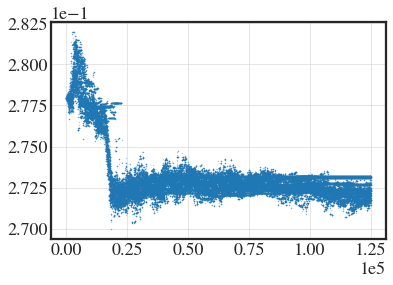

In [294]:
plt.scatter(np.arange(len(res4.flatchain['vphot'])), res4.flatchain['vphot'], s=0.1, alpha=0.5)

In [293]:
#with open("./Data/OB1/5Pcygni", 'wb') as outfile:
#    pickle.dump(res4, outfile)

#### Markov Chain Monto Carlo to sample distribution


In [204]:
(9750+10000)/2, (10000+10250)/2

(9875.0, 10125.0)

In [282]:
mini = lmfit.Minimizer(lnprob, p) 

start = time.time()
nwalkers = 20 #v = p.valuesdict()

#res_list = []
lam0 = [7750,11750]#9250, 9750, 10250, 10750]
for i in lam0: 
    p['lam2'].value=i

    res4 = mini.emcee(nwalkers=nwalkers, burn=0, steps=2500, thin=1, params=p, seed=1, workers = 4)
    res_list.append(res4)
end = time.time()

print('Time elapsed [hours]:',(end-start)/60/60 )

#with open("./Data/OB1/OB1_3_peaks_XL_4.pkl", 'wb') as outfile:
#    pickle.dump(res2, outfile) 

100%|██████████| 2500/2500 [1:02:02<00:00,  1.49s/it]   


The chain is shorter than 50 times the integrated autocorrelation time for 8 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [135.68266733 147.01456887 218.7502631  273.24903333 307.96456038
 311.37560809 251.02199814 248.37484532]


100%|██████████| 2500/2500 [28:55<00:00,  1.44it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 8 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [ 79.77511083  92.31840288 166.78793322 288.64503376 323.54052994
 328.23494948 301.8796373  294.78987639]
Time elapsed [hours]: 1.5167854955461288


In [285]:
for res in res_list:
    print(res.params['lam2'].value)
    file = "./Data/OB1/4th/lam2_"+str(res.params['lam2'].value)+"_20x3000.pkl"
    with open(file, 'wb') as outfile:
        pickle.dump(res, outfile)

9000
9500
10000
10500
11000
9250
9750
10250
10750
8500
8750
11250
11500
8000
8250
9625
10375
9875
10125
7750
11750


42.67560757560044 0.6558788296026161
42.34356685640345 0.6958415243902544
41.416455026835095 0.6329445130295897
42.81604343755595 0.6503678197497138


42.74682056987357 0.645639754779324


Text(0.5, 0, '$d_L$')

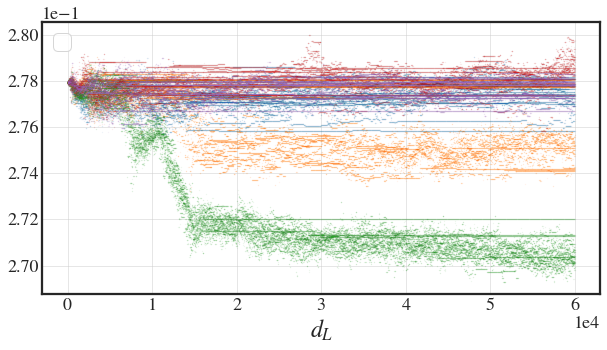

In [119]:
plt.figure(figsize=(10,5))
steady=20000
for res in res_list: 
    #print(np.mean(res.flatchain['vphot']), np.std(res.flatchain['vphot']))
    #plt.hist(res.flatchain['vphot'], bins=100, histtype='step')#, range=(0.25, 0.30))
    
    dl = lum_dist_arr( res.flatchain['N'], res.flatchain['vphot'], n_days=1.43 )*np.random.normal(loc=1, scale=0.015, size=len(res.flatchain['N']))
    plt.scatter(np.arange(len(res.flatchain['vphot'])), res.flatchain['vphot'], alpha=0.1, s=0.1)
    
    #plt.scatter(np.arange(len(res.flatchain['vphot']))[steady:], dl[steady:], alpha=0.1, s=0.1)
    #plt.hist(res.flatchain['vphot'], bins=100, histtype='stepfilled', label=str(res.params['lam2'].value)+'Å', density=True, range=(0.25, 0.30), alpha=0.2)
    
    #plt.hist(dl[steady:], bins=100, histtype='step', label=str(res.params['lam2'].value)+'Å', density=True)#, range=(0.25, 0.30))
    print(np.mean(dl[steady:]), np.std(dl[steady:]))
plt.legend(frameon=True, fontsize=22)

plt.xlabel(r'$d_L$')
#plt.xlabel(r'$v_{phot}$')
#plt.xlim(35.5,48)
#plt.savefig('Pictures/add_line_bias_dl.png', dpi=300)

11000

9000 0.005600406121545552
9500 0.4103236710639889
10000 6.779117735962156
10500 0.12496567006405379
11000 0.026311640777146594
9250 0.0037311938717877412
9750 2.093008873531399
10250 12.090813820044595
10750 0.10275653229418646
8500 0.0010661123155418434
8750 0.0010965390612669196
11250 0.01144707477119512
11500 0.009518484461247948
8000 0.001110690807276203
8250 0.0019941902778160014
9625 0.8770121441161385
10375 0.13664386648601345
9875 2.223653466696888
10125 3.4981849687960915
7750 0.0015570674817001013
11750 0.008052301442565395


(Text(0, 0.5, '$d_L$'), Text(0.5, 0, '$\\lambda_2$ [Å]'))

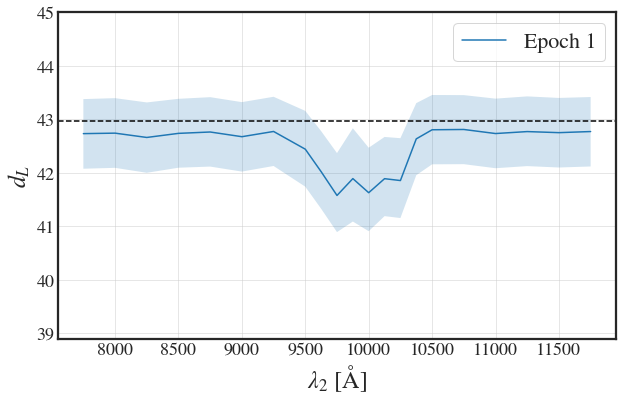

In [289]:
plt.figure(figsize=(10,6))
steady=20000

res_med = []
res_low = []
res_hig = []
lam = []

for res in res_list:
    dl = lum_dist_arr( res.flatchain['N'], res.flatchain['vphot'], n_days=1.43 )*np.random.normal(loc=1, scale=0.015, size=len(res.flatchain['N']))
    res_med.append(np.median(dl))
    res_low.append(np.percentile(dl, 15.9))
    res_hig.append(np.percentile(dl, 100-15.9)) 

    lam.append(res.params['lam2'].value) 
    print(res.params['lam2'].value, res.params['tau2'].value)

res_med = np.array([x for _, x in sorted(zip(lam, res_med))])
res_low = np.array([x for _, x in sorted(zip(lam, res_low))])
res_hig = np.array([x for _, x in sorted(zip(lam, res_hig))])
lam = np.array(np.sort(lam))


plt.plot(lam, res_med, label='Epoch 1')
plt.fill_between(lam, res_low, res_hig, alpha=0.2)
plt.ticklabel_format(axis='both', style='plain')

plt.ylim(38.9, 45); plt.axhline(42.96, ls='--', color='k')
plt.legend(frameon=True, fontsize=22)
plt.ylabel(r'$d_L$'), plt.xlabel(r'$\lambda_2$ [Å]')

9000
9500
10000
10500
11000
9250
9750
10250
10750
8500
8750
11250
11500
8000
8250
9625
10375
9875
10125


7750
11750


(Text(0, 0.5, '$d_L$'), Text(0.5, 0, '$\\lambda_2$'))

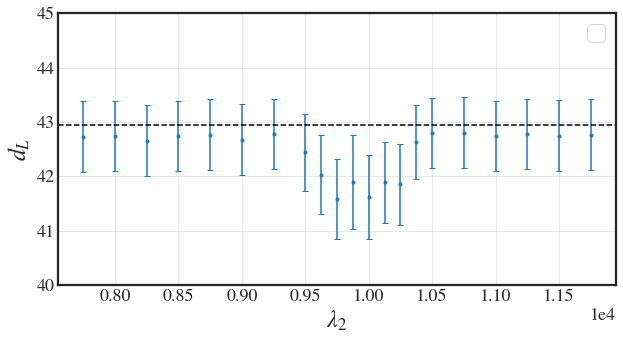

In [284]:
plt.figure(figsize=(10,5))
steady=20000

for res in res_list:
    dl = lum_dist_arr( res.flatchain['N'], res.flatchain['vphot'], n_days=1.43 )*np.random.normal(loc=1, scale=0.015, size=len(res.flatchain['N']))
    
    plt.errorbar(res.params['lam2'].value, np.median(dl), yerr = (np.percentile(dl, 100-15.9)-np.percentile(dl, 15.9))/2, 
                color='C0', capsize=3, fmt='.') 
    
    print(res.params['lam2'].value)
plt.legend(frameon=True, fontsize=22)
#plt.plot(lam, res_med, label='Epoch 1')
#plt.fill_between(lam, res_low, res_hig, alpha=0.2)
#plt.plot(lam, res_med)
#plt.fill_between(lam, res_low, res_hig, alpha=0.2)

plt.ylim(40, 45)
plt.axhline(42.95, ls='--', color='k')
plt.ylabel(r'$d_L$'), plt.xlabel(r'$\lambda_2$')

In [189]:
len(res_list)
res_list

In [206]:
#'./Data/OB1/4th/lam2_9000_20x3000.'

#with open("./Data/OB1/4th/lam2_9000_20x3000.pkl", 'wb') as outfile:
#    pickle.dump(res_list[0], outfile)
    
#with open("./Data/OB1/4th/lam2_9500_20x3000.pkl", 'wb') as outfile:
#    pickle.dump(res_list[1], outfile)
    
#with open("./Data/OB1/4th/lam2_10000_20x3000.pkl", 'wb') as outfile:
#    pickle.dump(res_list[2], outfile)
    
#with open("./Data/OB1/4th/lam2_10500_20x3000.pkl", 'wb') as outfile:
#    pickle.dump(res_list[3], outfile)
    
#with open("./Data/OB1/4th/lam2_11000_20x3000.pkl", 'wb') as outfile:
#    pickle.dump(res_list[4], outfile)

#with open("./Data/OB1/4th/lam2_9250_20x3000.pkl", 'wb') as outfile:
#    pickle.dump(res_list[5], outfile)

#with open("./Data/OB1/4th/lam2_9750_20x3000.pkl", 'wb') as outfile:
#    pickle.dump(res_list[6], outfile)

#with open("./Data/OB1/4th/lam2_10250_20x3000.pkl", 'wb') as outfile:
#    pickle.dump(res_list[7], outfile)

#with open("./Data/OB1/4th/lam2_10750_20x3000.pkl", 'wb') as outfile:
#    pickle.dump(res_list[8], outfile)

#with open("./Data/OB1/4th/lam2_8500_20x3000.pkl", 'wb') as outfile:
#    pickle.dump(res_list[9], outfile)

#with open("./Data/OB1/4th/lam2_8750_20x3000.pkl", 'wb') as outfile:
#    pickle.dump(res_list[10], outfile)

#with open("./Data/OB1/4th/lam2_11250_20x3000.pkl", 'wb') as outfile:
#    pickle.dump(res_list[11], outfile)

#with open("./Data/OB1/4th/lam2_11500_20x3000.pkl", 'wb') as outfile:
#    pickle.dump(res_list[12], outfile)

#with open("./Data/OB1/4th/lam2_8000_20x3000.pkl", 'wb') as outfile:
#    pickle.dump(res_list[13], outfile)

#with open("./Data/OB1/4th/lam2_8250_20x3000.pkl", 'wb') as outfile:
#    pickle.dump(res_list[14], outfile)
    
#with open("./Data/OB1/4th/lam2_9625_20x3000.pkl", 'wb') as outfile:
#    pickle.dump(res_list[15], outfile)

#with open("./Data/OB1/4th/lam2_10375_20x3000.pkl", 'wb') as outfile:
#    pickle.dump(res_list[16], outfile)

#with open("./Data/OB1/4th/lam2_9875_20x3000.pkl", 'wb') as outfile:
#    pickle.dump(res_list[17], outfile)

#with open("./Data/OB1/4th/lam2_10125_20x3000.pkl", 'wb') as outfile:
#    pickle.dump(res_list[18], outfile)


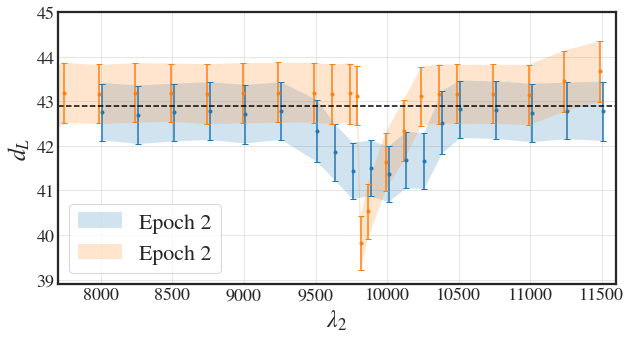

In [281]:
steady=40000

files = ["./Data/OB1/4th/lam2_8000_20x3000.pkl", "./Data/OB1/4th/lam2_8250_20x3000.pkl",
         "./Data/OB1/4th/lam2_8500_20x3000.pkl", "./Data/OB1/4th/lam2_8750_20x3000.pkl",
        "./Data/OB1/4th/lam2_9000_20x3000.pkl" , "./Data/OB1/4th/lam2_9250_20x3000.pkl", 
        "./Data/OB1/4th/lam2_9500_20x3000.pkl" , "./Data/OB1/4th/lam2_9625_20x3000.pkl", 
        "./Data/OB1/4th/lam2_9750_20x3000.pkl" , "./Data/OB1/4th/lam2_9875_20x3000.pkl", 
        "./Data/OB1/4th/lam2_10000_20x3000.pkl", "./Data/OB1/4th/lam2_10125_20x3000.pkl",
        "./Data/OB1/4th/lam2_10250_20x3000.pkl", "./Data/OB1/4th/lam2_10375_20x3000.pkl",
        "./Data/OB1/4th/lam2_10500_20x3000.pkl", "./Data/OB1/4th/lam2_10750_20x3000.pkl",
        "./Data/OB1/4th/lam2_11000_20x3000.pkl", "./Data/OB1/4th/lam2_11250_20x3000.pkl",
        "./Data/OB1/4th/lam2_11500_20x3000.pkl"]

plt.figure(figsize=(10,5))
res_med = []; res_low = []; res_hig = []; lam = []

for file in files: 
    pickle_in = open(file,"rb")
    res = pickle.load(pickle_in)
    
    dl = lum_dist_arr( res.flatchain['N'], res.flatchain['vphot'], n_days=1.43 )*np.random.normal(loc=1, scale=0.015, size=len(res.flatchain['N']))

    plt.errorbar(res.params['lam2'].value+10, np.median(dl[steady:]), yerr = (np.percentile(dl[steady:], 100-15.9)-np.percentile(dl[steady:], 15.9))/2, 
                color='C0', capsize=3, fmt='.') 
    #print(file, res.params['lam2'].value)
    res_med.append(np.median(dl[steady:])); res_low.append(np.percentile(dl[steady:], 15.9)); res_hig.append(np.percentile(dl[steady:], 100-15.9)) 
    lam.append(res.params['lam2'].value) 

res_med1 = np.array([x for _, x in sorted(zip(lam, res_med))]); res_low1 = np.array([x for _, x in sorted(zip(lam, res_low))])
res_hig1 = np.array([x for _, x in sorted(zip(lam, res_hig))]); lam1 = np.array(np.sort(lam))

plt.ylim(38.2, 45)
plt.axhline(42.9, ls='--', color='k')
plt.ylabel(r'$d_L$'), plt.xlabel(r'$\lambda_2$')
plt.ticklabel_format(axis='both', style='plain')


res_med = []; res_low = []; res_hig = []; lam = []
for file in os.listdir("./Data/OB2/4th/"): 
    file_loc = "./Data/OB2/4th/"+file
    pickle_in = open(file_loc,"rb")
    res = pickle.load(pickle_in)
    
    dl = lum_dist_arr( res.flatchain['N'], res.flatchain['vphot'], n_days=2.42 )*np.random.normal(loc=1, scale=0.015, size=len(res.flatchain['N']))

    plt.errorbar(res.params['lam2'].value-10, np.median(dl[steady:]), yerr = [[np.percentile(dl[steady:], 100-15.9)-np.median(dl[steady:])], 
                                                                           [np.median(dl[steady:])-np.percentile(dl[steady:], 15.9)]], 
                color='C1', capsize=3, fmt='.') 
    res_med.append(np.median(dl[steady:])); res_low.append(np.percentile(dl[steady:], 15.9)); res_hig.append(np.percentile(dl[steady:], 100-15.9)) 

    lam.append(res.params['lam2'].value) 
    


res_med2 = np.array([x for _, x in sorted(zip(lam, res_med))])
res_low2 = np.array([x for _, x in sorted(zip(lam, res_low))])
res_hig2 = np.array([x for _, x in sorted(zip(lam, res_hig))])
lam2 = np.array(np.sort(lam))
plt.fill_between(lam1+10, res_low1, res_hig1, alpha=0.2, label='Epoch 2')
plt.fill_between(lam2-10, res_low2, res_hig2, alpha=0.2, label='Epoch 2')

#f1l = interp1d(lam1, res_low1, kind='quadratic')(x); f1h = interp1d(lam1, res_hig1, kind='quadratic')(x)
#f2l = interp1d(lam2, res_low2, kind='quadratic')(x); f2h = interp1d(lam2, res_hig2, kind='quadratic')(x)
#plt.fill_between(x, f1l, f1h, alpha=0.2, label='Epoch 1')
#plt.fill_between(x-20, f2l, f2h, alpha=0.2, label='Epoch 2')

plt.ylim(38.9, 45), plt.xlim(7700, 11600)
plt.legend(frameon=True, fontsize=22)


In [256]:
np.percentile(dl[steady:], 100-15.9)-np.median(dl[steady:])

0.6390465457874086

In [283]:
2/43

0.046511627906976744

(Text(0, 0.5, '$d_L$'), Text(0.5, 0, '$\\lambda_2$ [Å]'))

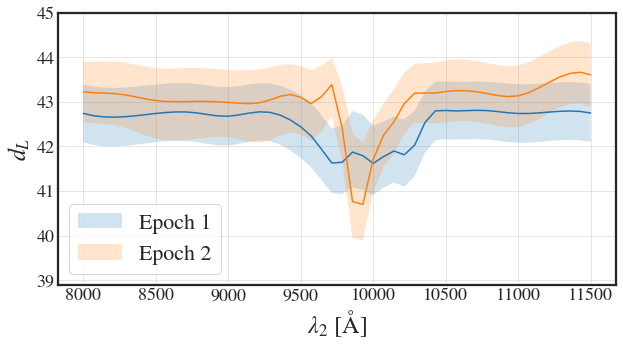

In [253]:
from scipy.interpolate import interp1d
x = np.linspace(8000, 11500)
plt.figure(figsize=(10,5))

#plt.plot(lam1, res_med1, label='Epoch 1')
#plt.fill_between(lam1, res_low1, res_hig1, alpha=0.2)
f1 = interp1d(lam1, res_med1, kind='cubic')(x)
plt.plot(x, f1)
f1l = interp1d(lam1, res_low1, kind='cubic')(x); f1h = interp1d(lam1, res_hig1, kind='cubic')(x)
plt.fill_between(x, f1l, f1h, alpha=0.2, label='Epoch 1')

#plt.plot(lam2[2:], res_med2[2:])
#plt.fill_between(lam2[2:], res_low2[2:], res_hig2[2:], alpha=0.2)

f2 = interp1d(lam2, res_med2, kind='cubic')(x)
f2l = interp1d(lam2, res_low2, kind='cubic')(x); f2h = interp1d(lam2, res_hig2, kind='cubic')(x)
plt.plot(x, f2)
plt.fill_between(x, f2l, f2h, alpha=0.2, label='Epoch 2')

plt.ticklabel_format(axis='both', style='plain')

plt.ylim(38.9, 45)
#; plt.axhline(42.96, ls='--', color='k')
plt.legend(frameon=True, fontsize=22)
plt.ylabel(r'$d_L$'), plt.xlabel(r'$\lambda_2$ [Å]')

In [229]:
lam2

array([ 7500,  7750,  8000,  8250,  8500,  8750,  9000,  9250,  9500,
        9625,  9750,  9875, 10000, 10125, 10250, 10375, 10500, 10750,
       11000, 11250, 11500])

In [224]:
#np.sort(os.listdir("./Data/OB2/4th/"))

In [ ]:
res.flatchain['vphot']

In [102]:
len(res_list[0].flatchain['vphot'])

60000

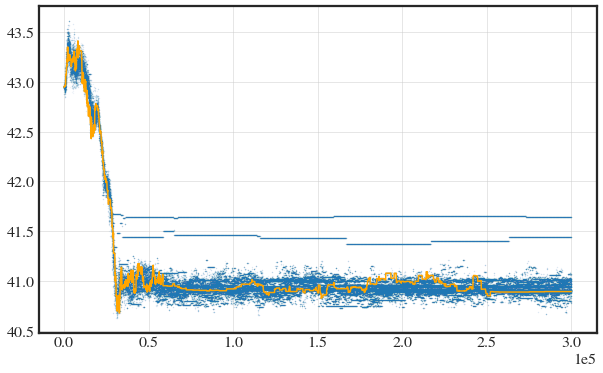

In [53]:
flat = res4.flatchain

plt.figure(figsize=(10,6))
dl = lum_dist_arr( flat['N'], flat['vphot'], n_days=1.43 ) #* np.sqrt(np.pi)
plt.scatter(np.arange(len(dl)), dl, s=0.1, alpha=0.1)
plt.plot(np.arange(len(dl))[::30], dl[::30], color='orange')

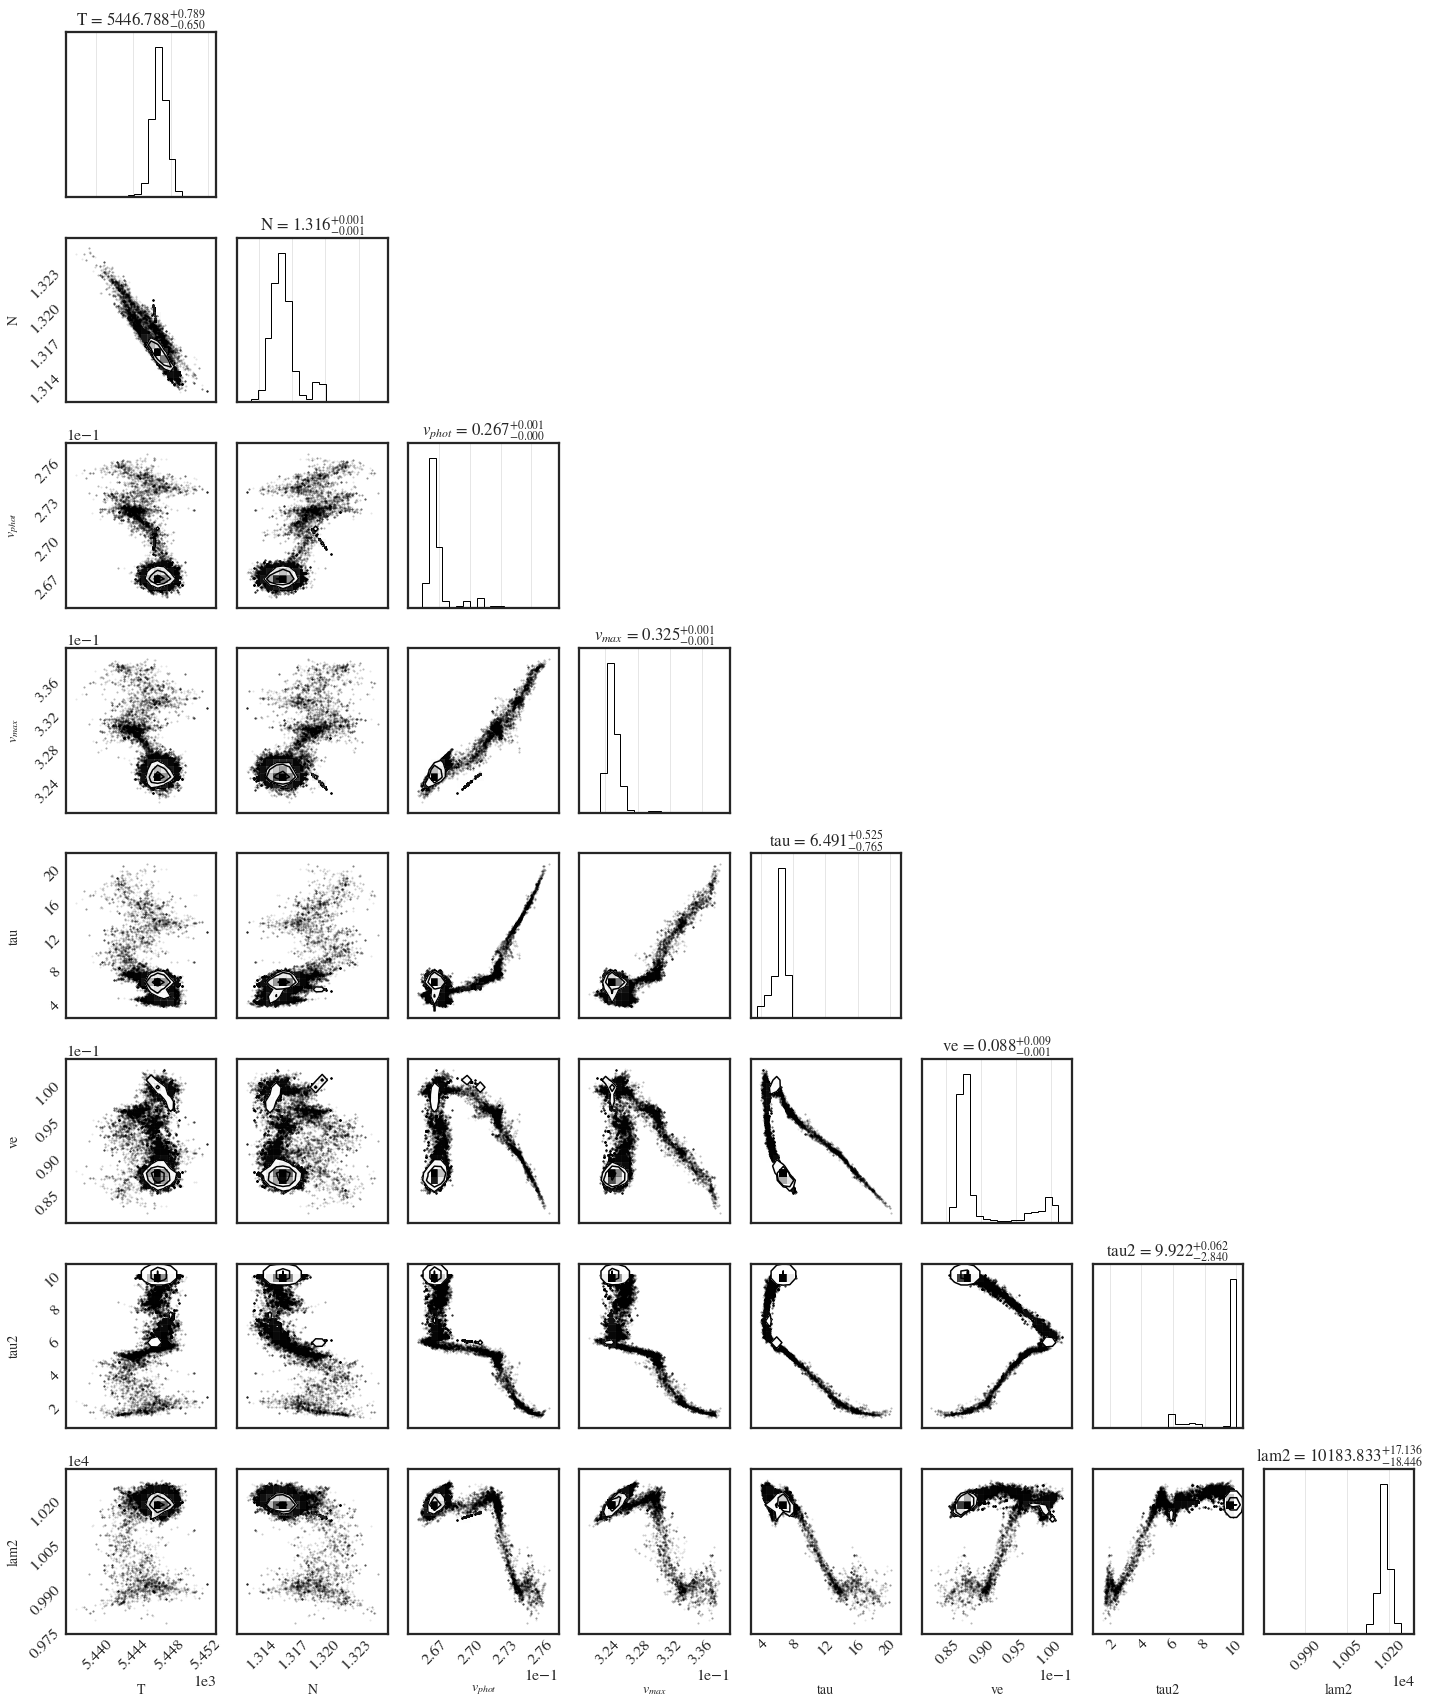

In [54]:
n_box = 8
fig,ax = plt.subplots(figsize=(20,24),nrows=n_box,ncols=n_box)
#ax = ax.flatten()
rej = 20000
reset_plt(16, 14)
corner.corner( np.array([flat['T'][rej:], flat['N'][rej:]*1e29, flat['vphot'][rej:], flat['vmax'][rej:], 
                         flat['tau'][rej:], flat['ve'][rej:], flat['tau2'][rej:], flat['lam2'][rej:]]).T, 
              labels=['T', 'N', r'$v_{phot}$', r'$v_{max}$','tau','ve', 'tau2', 'lam2'], 
              show_titles=True, fig=fig, title_fmt = '.3f'); 
plt.tight_layout() 

#plt.savefig('Pictures/OB1_covariance_large_n.png', dpi=300)

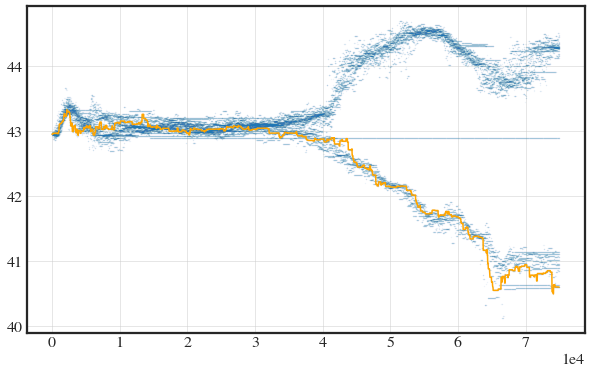

In [44]:
flat = res3.flatchain

plt.figure(figsize=(10,6))
dl = lum_dist_arr( flat['N'], flat['vphot'], n_days=1.43 ) #* np.sqrt(np.pi)
plt.scatter(np.arange(len(dl)), dl, s=0.1, alpha=0.1)
plt.plot(np.arange(len(dl))[::30], dl[::30], color='orange')

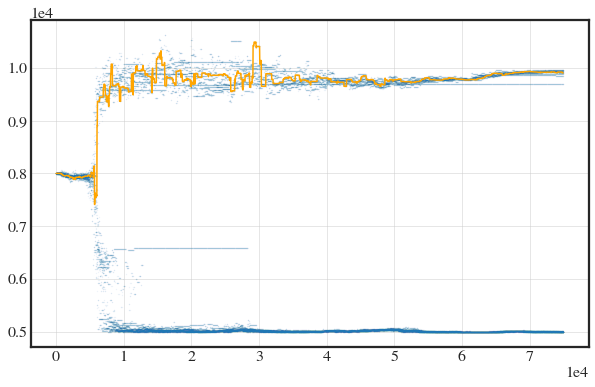

In [46]:
flat = res3.flatchain

plt.figure(figsize=(10,6))
plt.scatter(np.arange(len(dl)), flat['lam2'], s=0.1, alpha=0.1)
plt.plot(np.arange(len(dl))[::30], flat['lam2'][::30], color='orange')

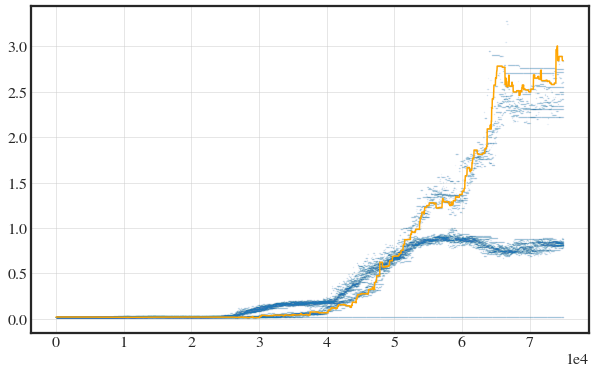

In [48]:
flat = res3.flatchain

plt.figure(figsize=(10,6))
plt.scatter(np.arange(len(dl)), flat['tau2'], s=0.1, alpha=0.1)
plt.plot(np.arange(len(dl))[::30], flat['tau2'][::30], color='orange')

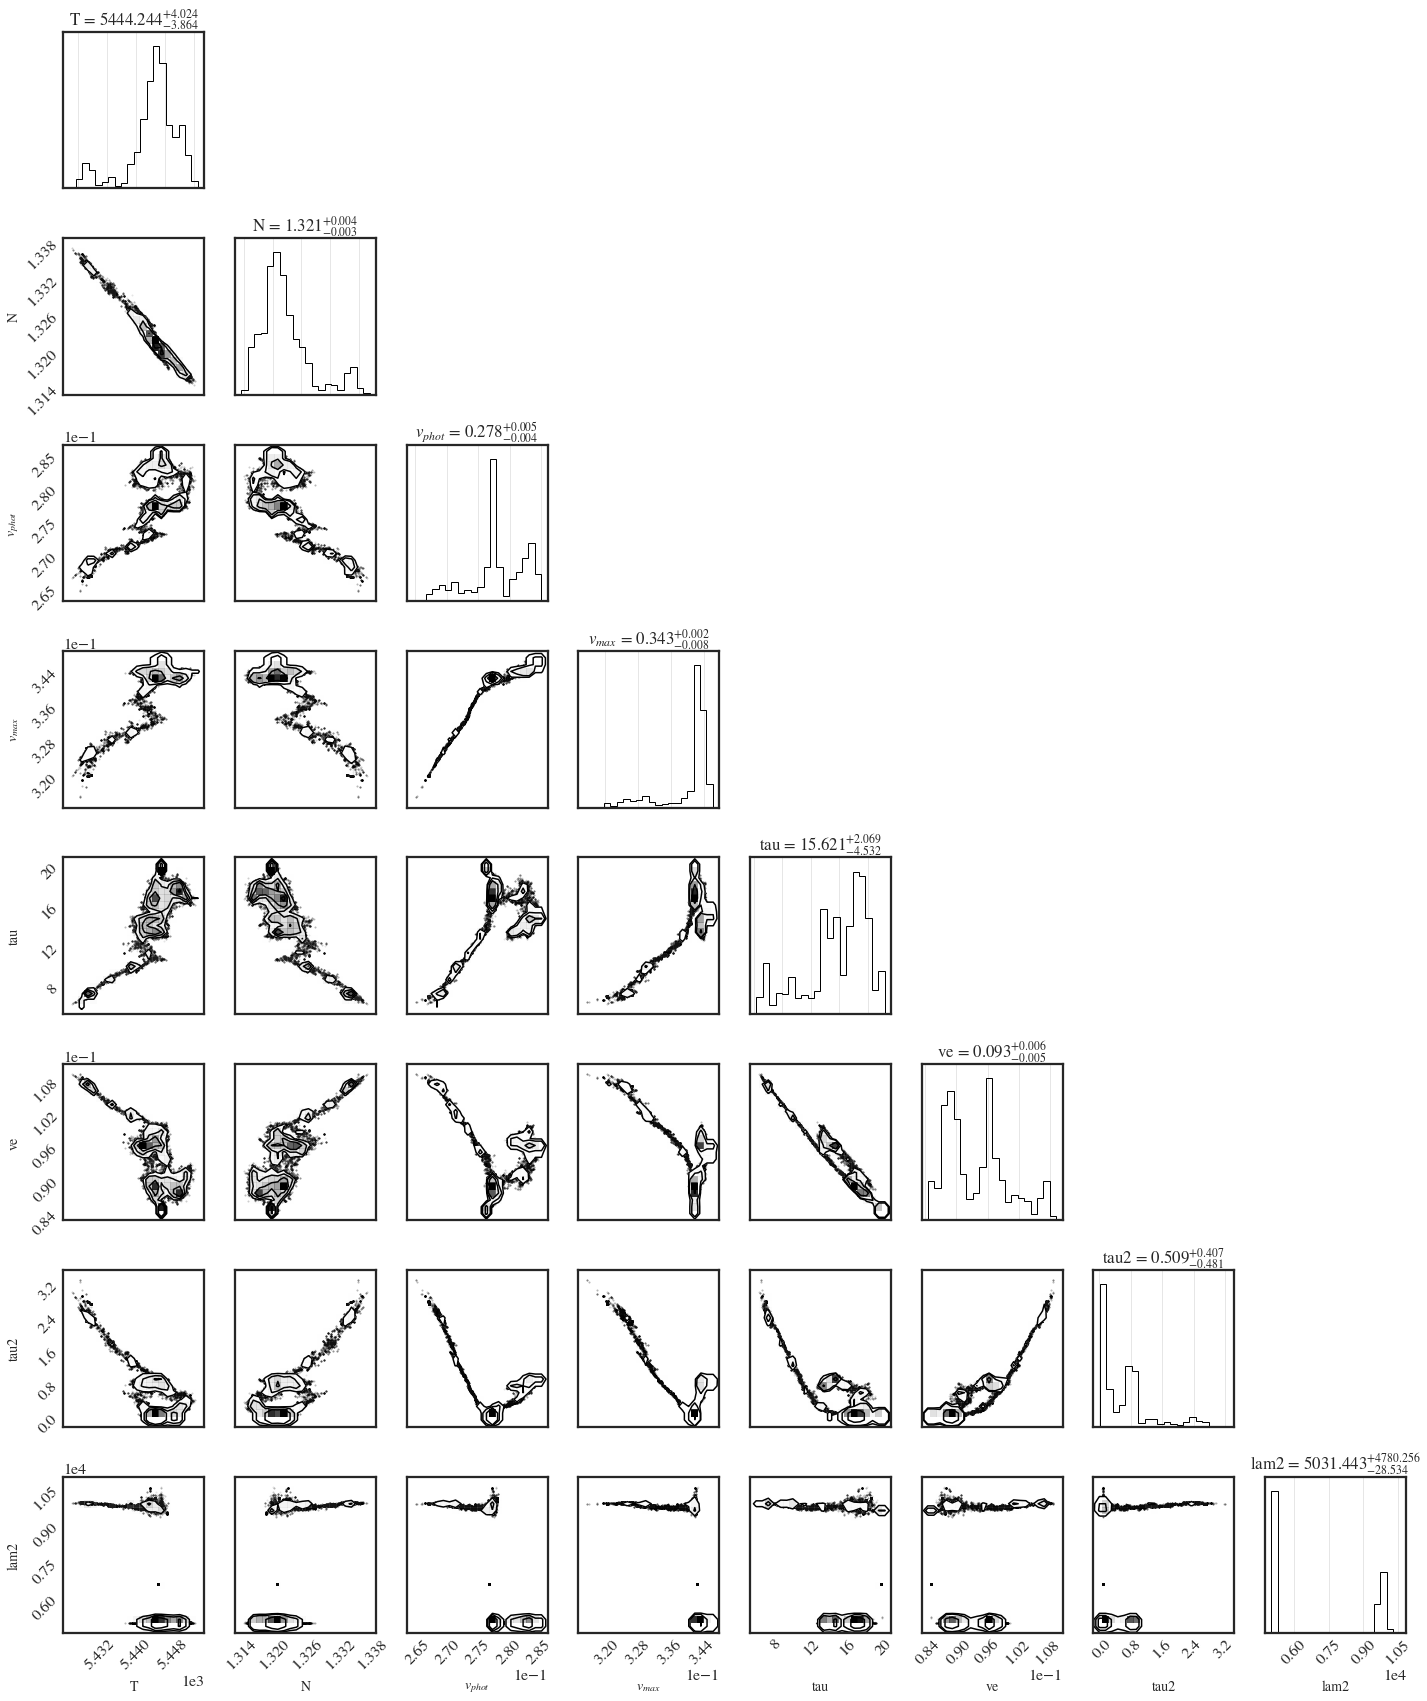

In [47]:
n_box = 8
fig,ax = plt.subplots(figsize=(20,24),nrows=n_box,ncols=n_box)
#ax = ax.flatten()
rej = 20000
reset_plt(16, 14)
corner.corner( np.array([flat['T'][rej:], flat['N'][rej:]*1e29, flat['vphot'][rej:], flat['vmax'][rej:], 
                         flat['tau'][rej:], flat['ve'][rej:], flat['tau2'][rej:], flat['lam2'][rej:]]).T, 
              labels=['T', 'N', r'$v_{phot}$', r'$v_{max}$','tau','ve', 'tau2', 'lam2'], 
              show_titles=True, fig=fig, title_fmt = '.3f'); 
plt.tight_layout() 

#plt.savefig('Pictures/OB1_covariance_large_n.png', dpi=300)

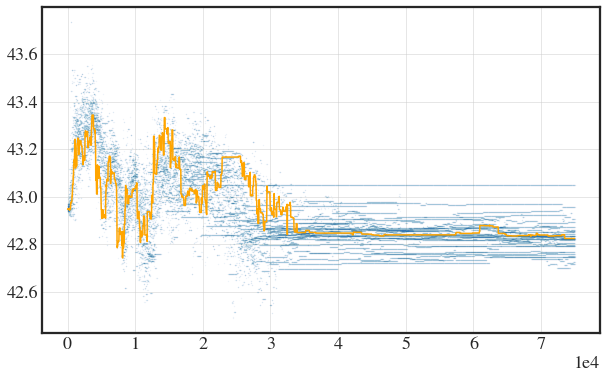

In [27]:
flat = res2.flatchain

plt.figure(figsize=(10,6))
dl = lum_dist_arr( flat['N'], flat['vphot'], n_days=1.43 ) #* np.sqrt(np.pi)
plt.scatter(np.arange(len(dl)), dl, s=0.1, alpha=0.1)
plt.plot(np.arange(len(dl))[::30], dl[::30], color='orange')

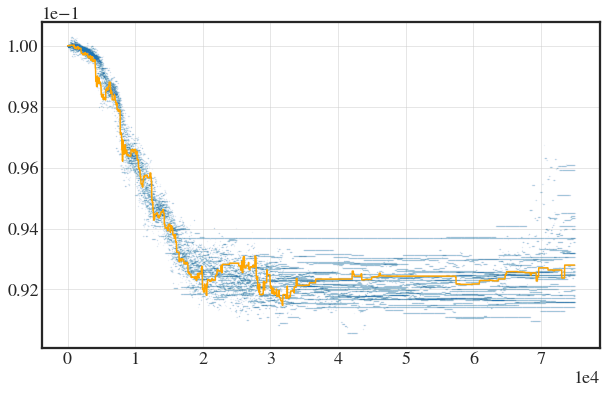

In [29]:
flat = res2.flatchain

plt.figure(figsize=(10,6))
plt.scatter(np.arange(len(dl)), flat['tau2'], s=0.1, alpha=0.1)
plt.plot(np.arange(len(dl))[::30], flat['tau2'][::30], color='orange')

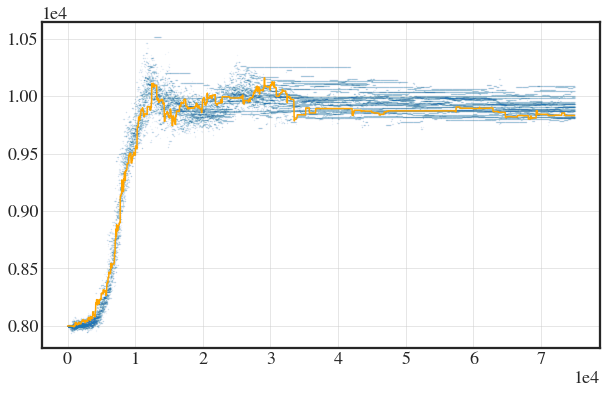

In [30]:
flat = res2.flatchain

plt.figure(figsize=(10,6))
plt.scatter(np.arange(len(dl)), flat['lam2'], s=0.1, alpha=0.1)
plt.plot(np.arange(len(dl))[::30], flat['lam2'][::30], color='orange')

In [32]:
import corner

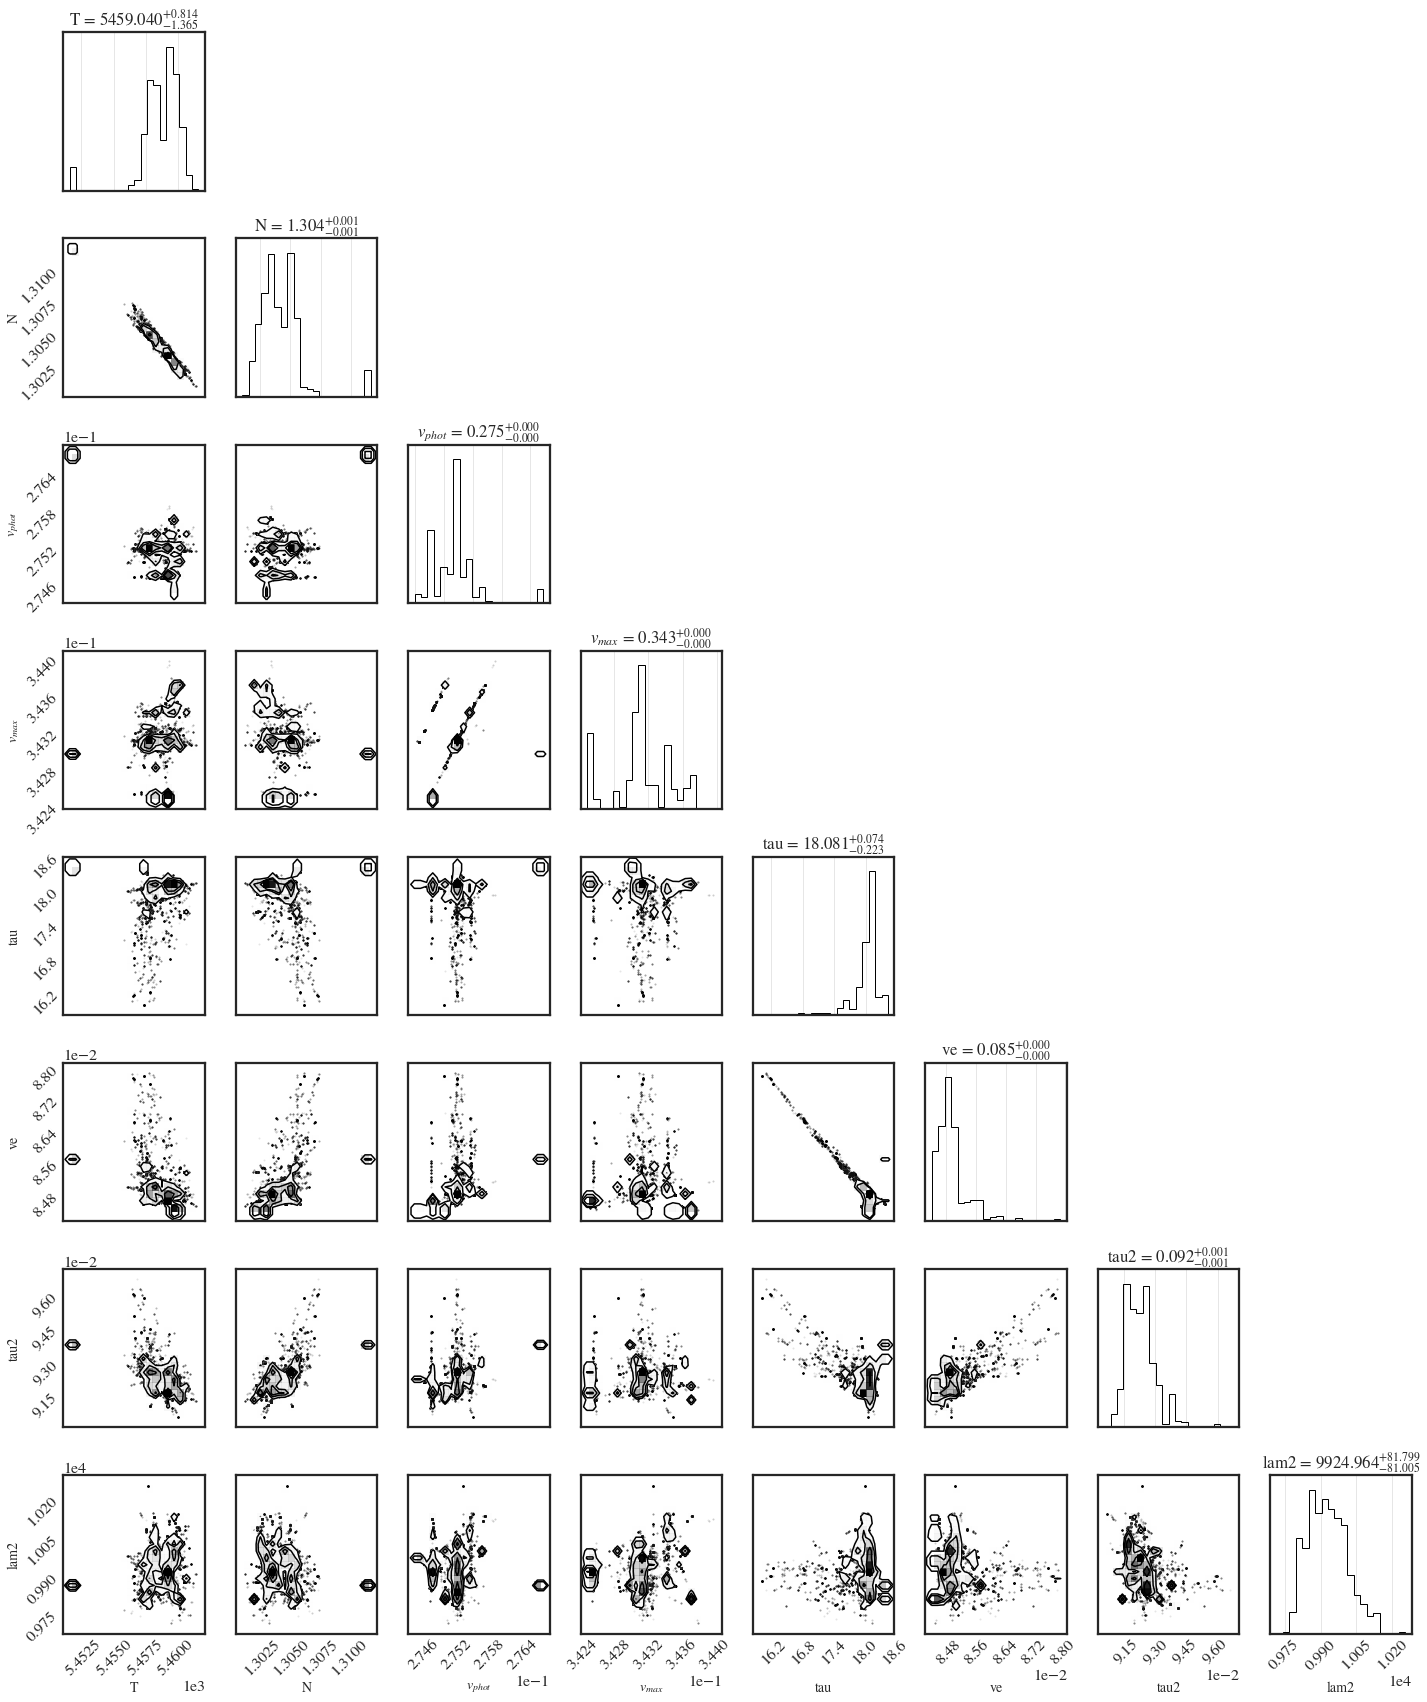

In [37]:
n_box = 8
fig,ax = plt.subplots(figsize=(20,24),nrows=n_box,ncols=n_box)
#ax = ax.flatten()
rej = 40000
reset_plt(16, 14)
corner.corner( np.array([flat['T'][rej:], flat['N'][rej:]*1e29, flat['vphot'][rej:], flat['vmax'][rej:], 
                         flat['tau'][rej:], flat['ve'][rej:], flat['tau2'][rej:], flat['lam2'][rej:]]).T, 
              labels=['T', 'N', r'$v_{phot}$', r'$v_{max}$','tau','ve', 'tau2', 'lam2'], 
              show_titles=True, fig=fig, title_fmt = '.3f'); 
plt.tight_layout() 

#plt.savefig('Pictures/OB1_covariance_large_n.png', dpi=300)

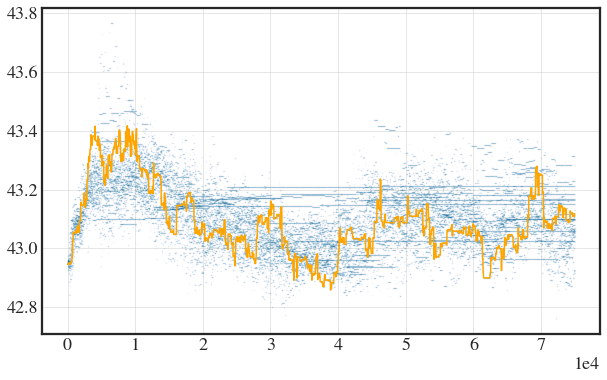

In [11]:
flat = res2.flatchain

plt.figure(figsize=(10,6))
dl = lum_dist_arr( flat['N'], flat['vphot'], n_days=1.43 ) #* np.sqrt(np.pi)
plt.scatter(np.arange(len(dl)), dl, s=0.1, alpha=0.1)
plt.plot(np.arange(len(dl))[::30], dl[::30], color='orange')

In [12]:
with open("./Data/OB1/OB1_lambda_3300_22500_woOccult_woPeak.pkl", 'wb') as outfile:
    pickle.dump(res2, outfile) 

array([0.361, 0.4  , 0.39 , 0.342, 0.417, 0.369, 0.411, 0.395, 0.402,
       0.368, 0.345, 0.394, 0.367, 0.391, 0.348, 0.285, 0.367, 0.359,
       0.401, 0.406, 0.381, 0.408, 0.395, 0.384, 0.369, 0.349, 0.363,
       0.39 , 0.382, 0.4  ])

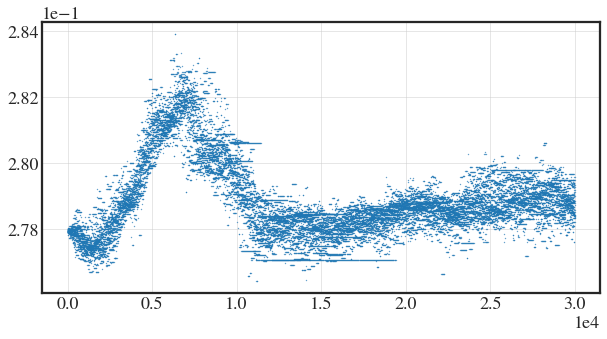

In [101]:
## with gaussian again all parameters free

flat = res2.flatchain

plt.figure(figsize=(10,5))
plt.scatter( np.arange(len(flat['vphot'])), flat['vphot'], s=0.1, alpha=1 ) 
res2.acceptance_fraction

array([0.361, 0.4  , 0.39 , 0.342, 0.417, 0.369, 0.411, 0.395, 0.402,
       0.368, 0.345, 0.394, 0.367, 0.391, 0.348, 0.285, 0.367, 0.359,
       0.401, 0.406, 0.381, 0.408, 0.395, 0.384, 0.369, 0.349, 0.363,
       0.39 , 0.382, 0.4  ])

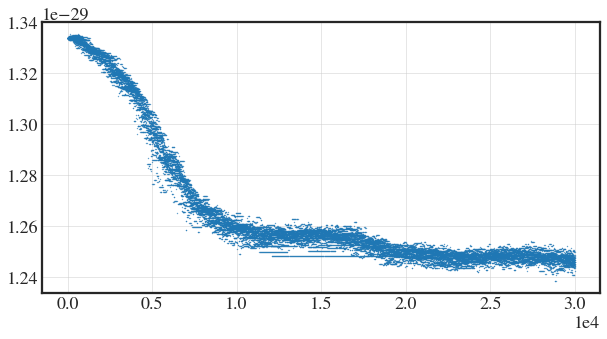

In [105]:
plt.figure(figsize=(10,5))
plt.scatter( np.arange(len(flat['vphot'])), flat['N'], s=0.1, alpha=1 ) 
res2.acceptance_fraction

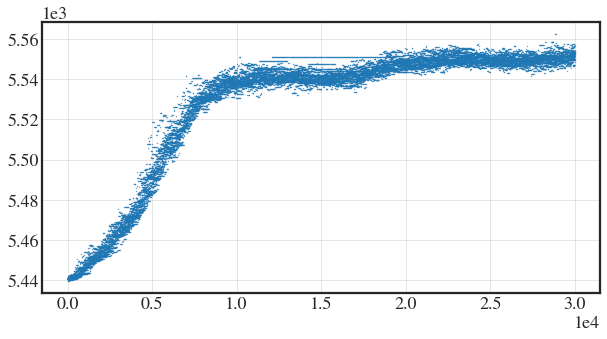

In [107]:
plt.figure(figsize=(10,5))
plt.scatter( np.arange(len(flat['vphot'])), flat['T'], s=0.1, alpha=1 ) 

array([0.0232, 0.0518, 0.1492, 0.1117, 0.0497, 0.0388, 0.0374, 0.0403,
       0.0236, 0.0078, 0.0451, 0.0588, 0.0061, 0.1462, 0.0624, 0.1439,
       0.0099, 0.0454, 0.0081, 0.0506])

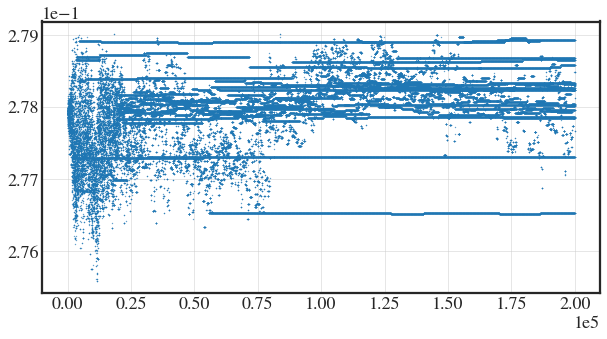

In [86]:
## with gaussian again all parameters free

flat = res2.flatchain

plt.figure(figsize=(10,5))
plt.scatter( np.arange(len(flat['vphot'])), flat['vphot'], s=0.1, alpha=1 ) 
res2.acceptance_fraction

In [84]:
with open("./Data/OB1/OB1_3_peaks_lambda_13000.pkl", 'wb') as outfile:
    pickle.dump(res2, outfile) 



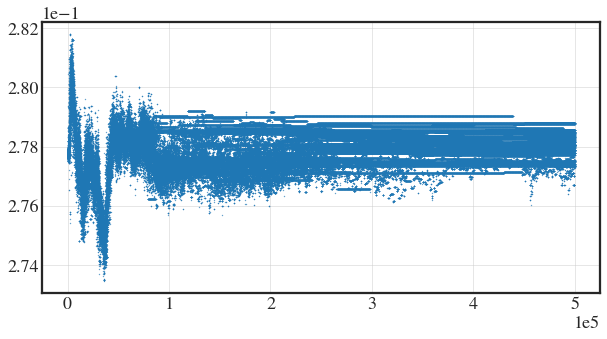

In [65]:
## with gaussian again all parameters free

flat = res2.flatchain

plt.figure(figsize=(10,5))
plt.scatter( np.arange(len(flat['vphot'])), flat['vphot'], s=0.1, alpha=1 ) 


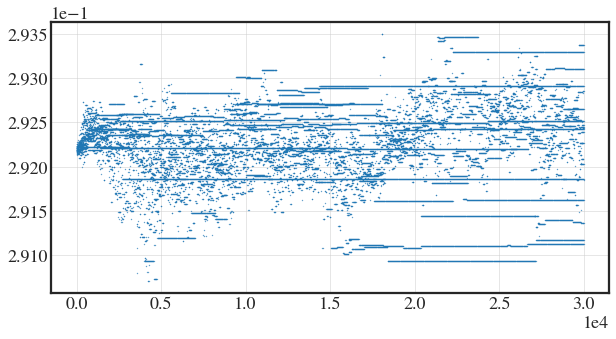

In [56]:
## no gaussian again with >4200 Å

flat = res2.flatchain

plt.figure(figsize=(10,5))
plt.scatter( np.arange(len(flat['vphot'])), flat['vphot'], s=0.1, alpha=1 ) 


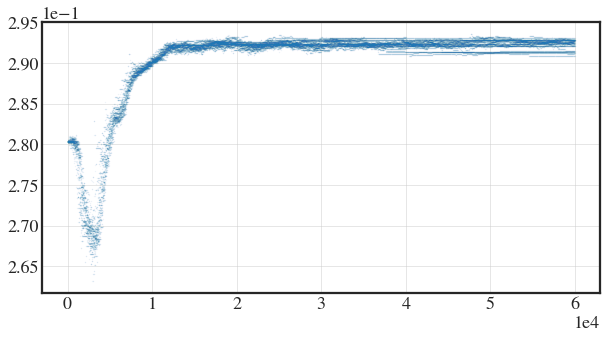

In [45]:
## no gaussian again with >4000 Å

flat = res2.flatchain

plt.figure(figsize=(10,5))
plt.scatter( np.arange(len(flat['vphot'])), flat['vphot'], s=0.1, alpha=0.1 ) 


In [66]:
with open("./Data/OB1/OB1_3_peaks_with_gaussian_3.pkl", 'wb') as outfile:
    pickle.dump(res2, outfile) 



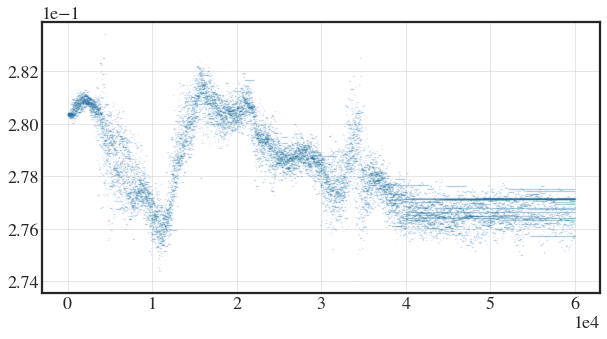

In [40]:
## gaussian again with free sig1

flat = res2.flatchain

plt.figure(figsize=(10,5))
plt.scatter( np.arange(len(flat['vphot'])), flat['vphot'], s=0.1, alpha=0.1 ) 


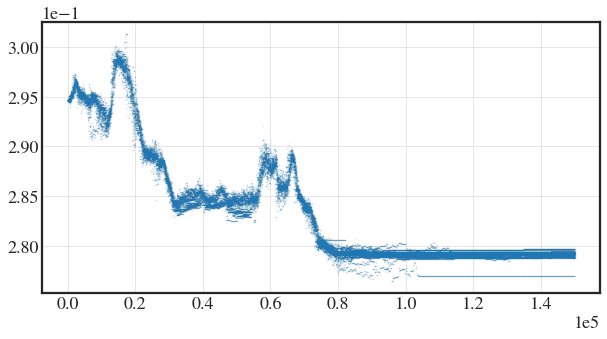

In [32]:
## gaussian again

flat = res2.flatchain

plt.figure(figsize=(10,5))
plt.scatter( np.arange(len(flat['vphot'])), flat['vphot'], s=0.1, alpha=0.1 ) 


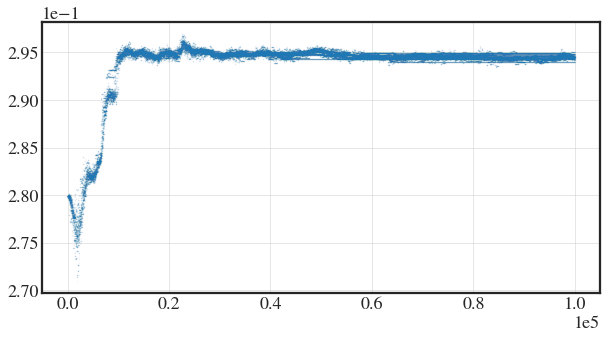

In [25]:
flat = res2.flatchain

plt.figure(figsize=(10,5))
plt.scatter( np.arange(len(flat['vphot'])), flat['vphot'], s=0.1, alpha=0.1 ) 


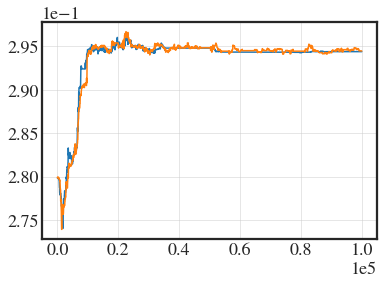

In [17]:
plt.plot( flat['vphot'][::nwalkers] ) 
plt.plot( flat['vphot'][1::nwalkers] ) 


#with open("./Data/OB1/OB1_3_peaks_filtered.pkl", 'wb') as outfile:
#    pickle.dump(res2, outfile) 

In [18]:
0.0004/0.28, 0.0006/0.25

(0.0014285714285714286, 0.0024)

In [19]:
res2.params

Parameters([('T', <Parameter 'T', value=5357.130320164423 +/- 1.05, bounds=[2500:7500]>), ('N', <Parameter 'N', value=1.444076557590604e-29 +/- 1.35e-32, bounds=[-inf:inf]>), ('vphot', <Parameter 'vphot', value=0.29464847488309165 +/- 0.000384, bounds=[0:1]>), ('vmax', <Parameter 'vmax', value=0.3423320690415769 +/- 0.000563, bounds=[0:1]>), ('t0', <Parameter 't0', value=126000 (fixed), bounds=[-inf:inf]>), ('tau', <Parameter 'tau', value=5.530907084060651 +/- 3.81, bounds=[0:100]>), ('vref', <Parameter 'vref', value=0.0 (fixed), bounds=[0:1]>), ('ve', <Parameter 've', value=0.18672828162112243 +/- 0.082, bounds=[0:1]>), ('occult', <Parameter 'occult', value=0.00025151236393796403 +/- 0.0183, bounds=[0:2]>), ('amp1', <Parameter 'amp1', value=0 (fixed), bounds=[0:5]>), ('amp2', <Parameter 'amp2', value=0 (fixed), bounds=[0:5]>), ('cen1', <Parameter 'cen1', value=1.55e-06 (fixed), bounds=[1.4e-06:1.7e-06]>), ('cen2', <Parameter 'cen2', value=2e-06 (fixed), bounds=[1.9e-06:2.2e-06]>), ('sig1', <Parameter 'sig1', value=1.1e-07 (fixed), bounds=[1e-08:3e-07]>), ('sig2', <Parameter 'sig2', value=1.3e-07 (fixed), bounds=[1e-08:3e-07]>)])

In [20]:
#with open("./Data/OB1/OB1_3_peaks_XL_2.pkl", 'wb') as outfile:
#    pickle.dump(res2, outfile) 

##### Plot d_l

In [ ]:
#pickle_in = open("./data/OB1/OB1_3_peaks_XL.pkl","rb")
#res2 = pickle.load(pickle_in)
#p = res2.params
#lum_dist_arr(p['N'],p['vphot'],n_days=1.43), p['ve'], p['vphot']

In [ ]:
res2

In [30]:
np.random.uniform(low=1.425, high=1.435, size=len(dl))/1.45

array([0.98298188, 0.98824831, 0.98928161, ..., 0.98768026, 0.98741743,
       0.98656749])

44.450917979361364 44.01112034661429 44.66594754305733
44.52959642258433 44.34126891355584 44.66143255112133


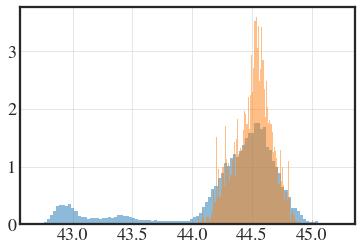

In [109]:
flat = res2.flatchain
dl = lum_dist_arr( flat['N'], flat['vphot'], n_days=1.43) #* np.sqrt(np.pi)
dl = dl*np.random.uniform(low=1.427, high=1.433, size=len(dl))/1.43
print(np.median(dl), np.percentile(dl, 15.9), np.percentile(dl, 100-15.9))
plt.hist(dl, bins=100, density=True, alpha=0.5); 
#nwalkers = 22
steady = int(500*nwalkers)
dl = lum_dist_arr( flat['N'][steady:], flat['vphot'][steady:], n_days=1.43) #* np.sqrt(np.pi)
plt.hist(dl, bins=100, density=True, alpha=0.5); 
print(np.median(dl), np.percentile(dl, 15.9), np.percentile(dl, 100-15.9))

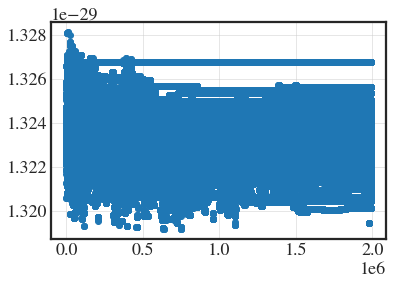

In [28]:
plt.scatter(np.arange(len(flat['vphot'][10000:])), flat['N'][10000:])


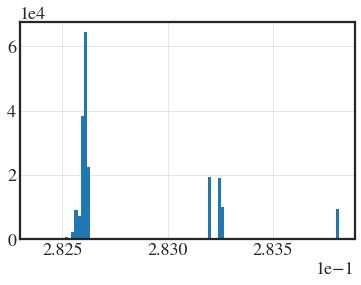

In [18]:
plt.hist(flat['vphot'][10000:], bins=100); 

In [199]:
0.00980*c*1e-3/45.7, 0.00980*c*1e-3/46.1

(64.33260393873086, 63.77440347071583)

In [17]:
import corner

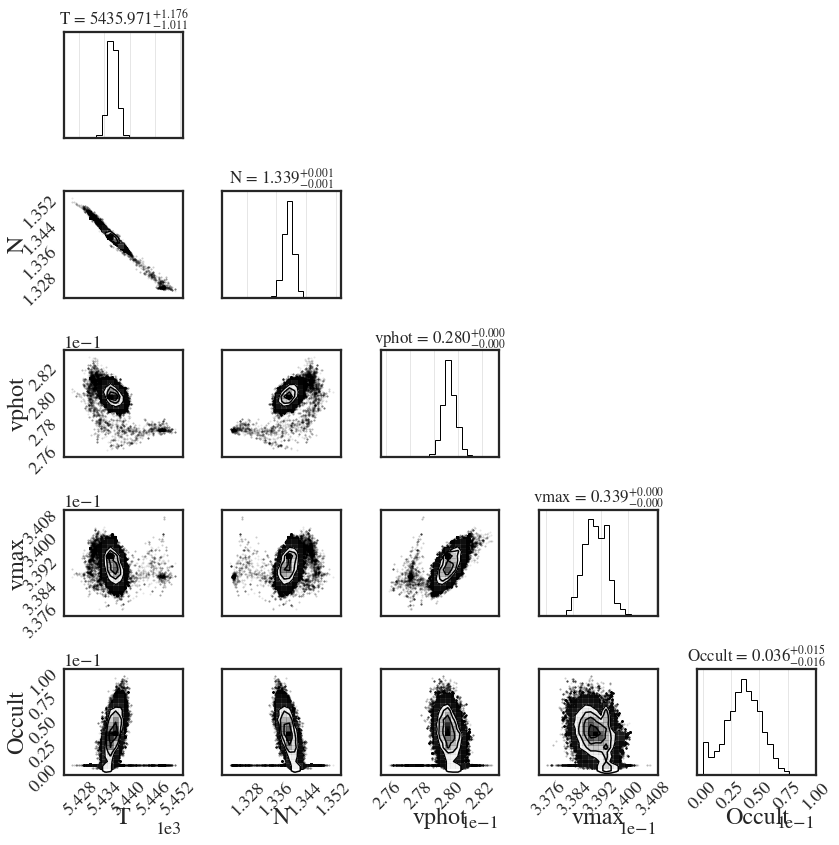

In [18]:
fig,ax = plt.subplots(figsize=(12,12),nrows=5,ncols=5)
#ax = ax.flatten()
reset_plt(16, 14)
corner.corner( np.array([flat['T'], flat['N']*1e29, flat['vphot'], flat['vmax'], flat['occult']]).T, 
            labels=['T', 'N', 'vphot','vmax', 'Occult'], show_titles=True, 
            fig=fig, title_fmt = '.3f'); 
plt.tight_layout() 

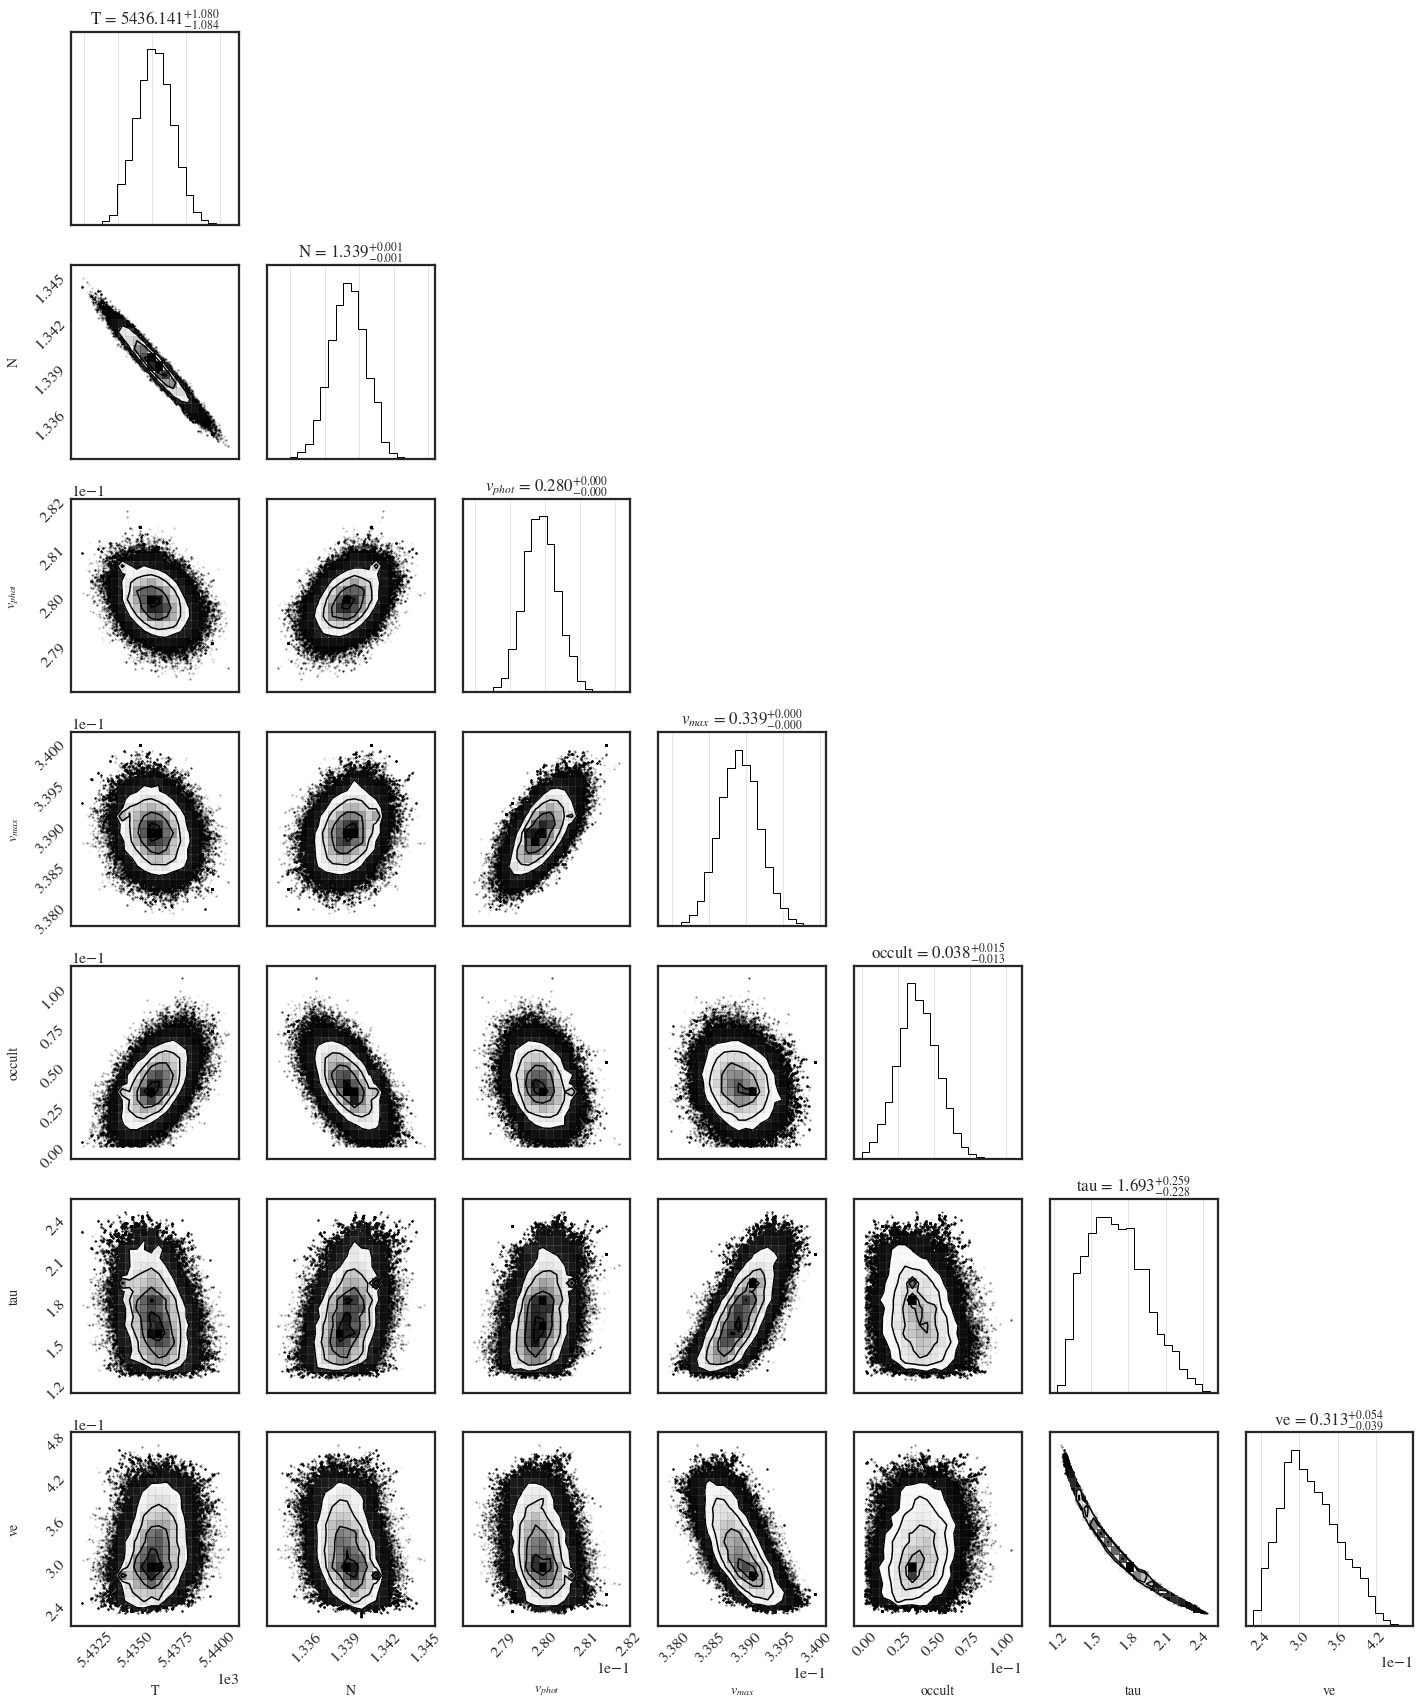

In [20]:
n_box = 7
fig,ax = plt.subplots(figsize=(20,24),nrows=n_box,ncols=n_box)
#ax = ax.flatten()
reset_plt(16, 14)
corner.corner( np.array([flat['T'], flat['N']*1e29, flat['vphot'], flat['vmax'], flat['occult'], flat['tau'], flat['ve']]).T, 
              labels=['T', 'N', r'$v_{phot}$', r'$v_{max}$','occult','tau','ve'], 
              show_titles=True, fig=fig, title_fmt = '.3f'); 
plt.tight_layout() 

#plt.savefig('Pictures/OB1_covariance_large_n.png', dpi=300)

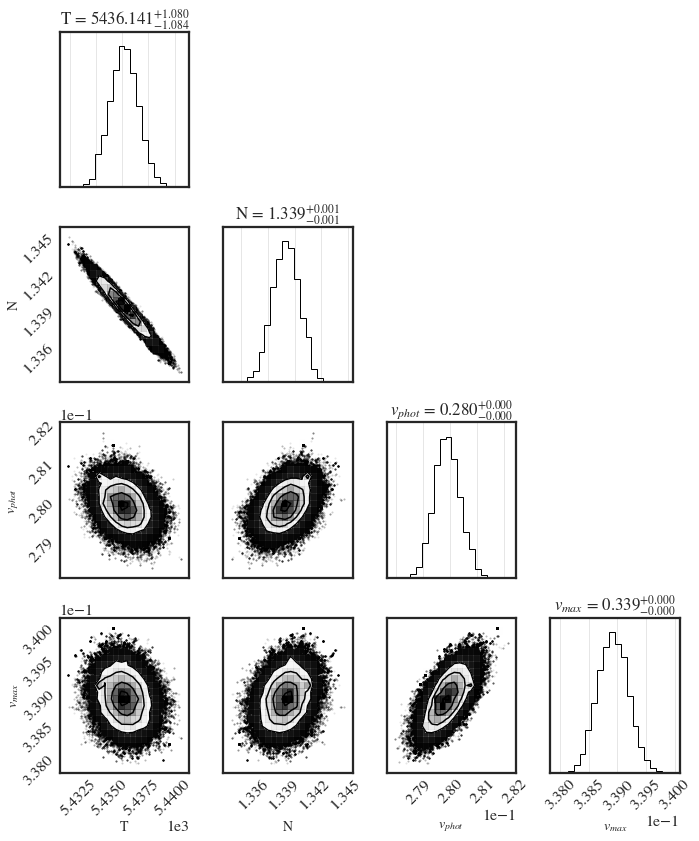

In [21]:
n_box = 4
fig,ax = plt.subplots(figsize=(10,12),nrows=n_box,ncols=n_box)
#ax = ax.flatten()
reset_plt(16, 14)
corner.corner( np.array([flat['T'], flat['N']*1e29, flat['vphot'], flat['vmax']]).T, 
              labels=['T', 'N', r'$v_{phot}$', r'$v_{max}$'], 
              show_titles=True, fig=fig, title_fmt = '.3f'); 
plt.tight_layout() 

#plt.savefig('Pictures/OB1_covariance_small_n.png', dpi=300)

In [60]:
## day 1
1+(23-12)/24+(21-41)/24/60

#23:45:35
#23:34:00
#23:22:22
#23:57:12
        
dtime1 = 1 + (23-12)/24 + (np.mean([16])-41)/(24*60)
dtime1

1.440972222222222

In [61]:
## day 2
2+(23-12)/24+(28-41)/24/60

# 23:53:42
# 23:58:38
# 23:38:35
# 23:28:45

dtime2 = 2 + (23-12)/24 + (np.mean([23])-41)/(24*60)
dtime2

2.4458333333333333

In [54]:
3+(24-12)/24+(5-41)/24/60

#  23:25:24
#  23:37:01
#  23:48:40
#  00:23:28
#  00:11

dtime3 = 3 + (23-12)/24 + (np.mean([25, 37, 48, 23+60, 11+60])-41)/(24*60)
dtime3

3.466527777777778

In [58]:
30/24/60

0.020833333333333332

In [62]:
3+(24-12)/24+(5-41)/24/60

#  23:50
#  23:25
#  23:30
#  23:35

dtime4 = 4 + (23-12)/24 + (np.mean([13])-41)/(24*60)
dtime4

4.438888888888888

In [31]:
## day 4
4+(23-12)/24+(50-41)/24/60

4.464583333333333

In [40]:
30/24/60

0.020833333333333332